In [1]:
from data_generator import price_data_generator as pdg
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox,het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from IPython.display import HTML, display, Image
from statsmodels.stats import diagnostic
from math import ceil
from statsmodels.iolib.summary import Summary
from bs4 import BeautifulSoup
from statsmodels.iolib.summary2 import summary_col
from stargazer.stargazer import Stargazer
from PIL import Image,ImageDraw


import statsmodels.formula.api as smf
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
import warnings
import statsmodels.graphics.tsaplots as tsaplots
import itertools


warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)


C:\tools\Anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Question A

In [2]:
def display_html_side_by_side(htmls):
   
    side_by_side_html = f'<div style="display: flex; justify-content: space-between;">'
    for html in htmls:
        side_by_side_html += f'<div style="flex-basis: 48%;">{html}</div>'
    
    side_by_side_html += f'</div>'
    
    # Display the combined HTML
    display(HTML(side_by_side_html))


In [3]:
SP_ID = 'SP500'
FF_ID = 'EFFR'

inst_colours = {'BTC-USD':'darkorange','LTC-USD':'silver'}

inst_list = list(inst_colours.keys())


SP_data = pdg().get_fred_data(SP_ID)
FF_data = pdg().get_fred_data(FF_ID)


In [4]:
def colour(inst):
    return [inst_colours[i] for i in inst_colours.keys() if i in inst][0]
    

To download the relevant historical data for my cryptocurrencies, the S&P 500 and the Federal Funds rate, I developed a file to interact with the Yahoo Finance API and the FRED API (see appendix). Both of these APIs can curl the historical price data, which I need for the project. Using my price_data_generator class, I imported historical data over the following periods.

<table>
  <tr>
    <th>Instrument</th>
    <th>Start Date</th>
    <th>End Date</th>
    <th>API</th>
    <th>API Code</th>
  </tr>
  <tr>
    <td>Bitcoin</td>
    <td>01-09-2015</td>
    <td>31-08-2023</td>
    <td>Yahoo Finance</td>
    <td>BTC-USD</td>
  </tr>
  <tr>
    <td>Litecoin</td>
    <td>01-09-2015</td>
    <td>31-08-2023</td>
    <td>Yahoo Finance</td>
    <td>LTC-USD</td>
  </tr>
  <tr>
    <td>S&P 500</td>
    <td>01-09-2015</td>
    <td>31-08-2023</td>
    <td>FRED</td>
    <td>SP500</td>
  </tr>
  <tr>
    <td>Federal Funds Rate</td>
    <td>01-09-2015</td>
    <td>31-08-2023</td>
    <td>FRED</td>
    <td>EFFR</td>
  </tr>
</table>

After generating all the datasets I used an inner join in order to remove any days that any one of the products did not publish a price. Using the remaining close prices I generated log returns for each crypto currency using the following formula:

$$\displaystyle \large r_t = ln(\frac{P_t}{P_{t-1}})*100$$

Below you can see the first 10 entries of my current dataset.

In [5]:
inst_data  ={}
for inst in inst_list:
    inst_price_data = pdg().get_prices(inst)
    combined_data = pd.merge(inst_price_data,SP_data,left_on = ['date'],right_on = ['date'], how = 'inner')\
                        .merge(FF_data, on = 'date', how = 'inner')
    inst_data[inst] = combined_data

htmls = []
for (key,value) in inst_data.items():
    inst_data[key][f'{key}_log_ret'] = (np.log(value[f'{key}_close_px']) - np.log(value[f'{key}_close_px'].shift(1)))*100
    table_title = f"<h2>{key} data</h2>"
    html = inst_data[key].head(10)[['date',f'{key}_log_ret',f'{SP_ID}_price',f'{FF_ID}_price']].to_html(classes='table table-striped', index=False)
    html_output = f"<div>{table_title}{html}</div>"
    htmls.append(html_output)
    


display_html_side_by_side(htmls)


date,BTC-USD_log_ret,SP500_price,EFFR_price
2015-09-01,NaN,1913.85,0.14
2015-09-02,0.508520,1948.86,0.14
2015-09-03,-0.920554,1951.13,0.14
2015-09-04,1.361829,1921.22,0.14
2015-09-08,5.618211,1969.41,0.14
2015-09-09,-2.257995,1942.04,0.14
2015-09-10,0.129659,1952.29,0.14
2015-09-11,0.681174,1961.05,0.14
2015-09-14,-4.020925,1953.03,0.14
2015-09-15,-0.147521,1978.09,0.14


By taking the log-transformation of the crypto returns we are changing some properties of the time series itself. This approach helps to stabilise variance, improve normal approximation, and to improve linearity.

---
# Question B

Using the formula from part a, I generated the log returns for the S&P 500. My datasets now look like this:

In [6]:
htmls = []
for (key,value) in inst_data.items():
    inst_data[key][f'{key}_ret'] = (value[f'{key}_close_px']/value[f'{key}_close_px'].shift(1)-1)*100
    inst_data[key][f'{SP_ID}_log_ret'] = (np.log(value[f'{SP_ID}_price']) - np.log(value[f'{SP_ID}_price'].shift(1)))*100
    inst_data[key] = inst_data[key].loc[1:,].reset_index(drop = True)
    table_title = f"<h2>{key} data</h2>"
    html = inst_data[key].head(10)[['date',f'{key}_log_ret',f'{SP_ID}_log_ret',f'{FF_ID}_price']].to_html(classes='table table-striped', index=False)
    html_output = f"<div>{table_title}{html}</div>"
    htmls.append(html_output)
    
display_html_side_by_side(htmls)



#maybe graph log returns vs regular returns and talk about what the log returns does

date,BTC-USD_log_ret,SP500_log_ret,EFFR_price
2015-09-02,0.508520,1.812767,0.14
2015-09-03,-0.920554,0.116411,0.14
2015-09-04,1.361829,-1.544829,0.14
2015-09-08,5.618211,2.477360,0.14
2015-09-09,-2.257995,-1.399504,0.14
2015-09-10,0.129659,0.526408,0.14
2015-09-11,0.681174,0.447700,0.14
2015-09-14,-4.020925,-0.409803,0.14
2015-09-15,-0.147521,1.274972,0.14
2015-09-16,-0.528086,0.866769,0.14


Below I have plotted the log returns for each crypto along with the federal funds rate and the S&P log returns. As you can see the crypto's are vastly more volitile when compared to the market (S&P).

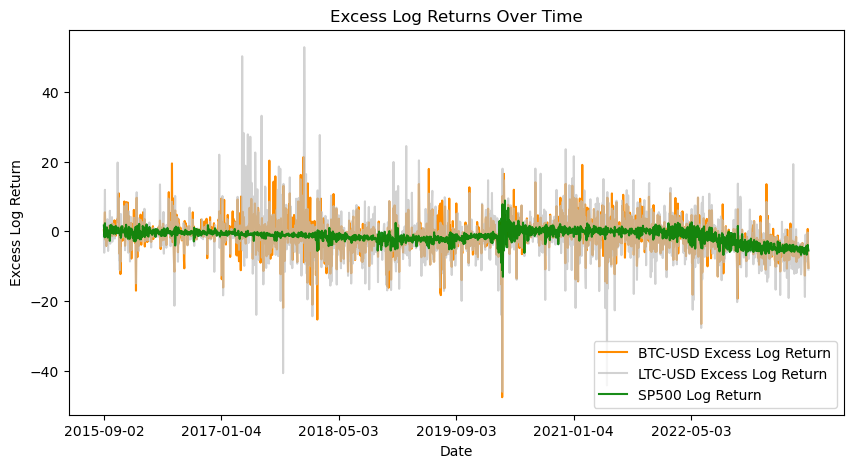

In [7]:
def plot_excess_returns(data = inst_data):

    plt.figure(figsize = (10,5))
    for inst in inst_list:
        data = inst_data[inst]
        inst_ex_log_ret = data[f'{inst}_log_ret']-data[f'{FF_ID}_price']
        plt.plot(data['date'],inst_ex_log_ret,color = colour(inst),label = f'{inst} Excess Log Return',alpha = (lambda x: 1 if inst == inst_list[0] else 0.7)(inst))
    SP_ex_log_ret = data[f'{SP_ID}_log_ret']-data[f'{FF_ID}_price']
    plt.plot(data['date'],SP_ex_log_ret,color='green',label = f'{SP_ID} Log Return',alpha = 0.9)
    plt.xlabel('Date')
    plt.ylabel('Excess Log Return')
    plt.xticks(data['date'][::333])
    plt.legend(loc = 'lower right')
    plt.title(f"Excess Log Returns Over Time")
    plt.show()

plot_excess_returns()

---
# Question C

Note on Statistical Significance:<br>
Statistical Significance is based on a level of alpha ($\alpha$) which is the probability of rejecting the null hypothesis given that it is true. Common levels of $\alpha$ are 1%,5% and 10%, throughout my project I have used (***),(**) and (*) to indicate levels respectively. 

## Form of the Model

Given the form of the Capital Asset Pricing Model:


$R_it-R_ft = \alpha_j + \beta_j(R_mt-R_ft)$


This model can be written in the form:

$Y_t = \beta_0 + \beta_1X_t + u_t$

where
$Y_t$ = $R_it-R_ft$, the excess return of the instrument (we are using log returns here)<br>
$X_t$ = $R_mt-R_ft$, the excess return of the market (we are using log returns here)<br>
$u_t$ = error term<br><br>
<b>What are error terms?</b><br>
The error terms are assumed to be present as we are taking a linear model to data which may not be linear.

So, to estimate this model, we need only fit a simple linear regression model to our data. Using Python, I have fit the regression models and presented the regression summaries below.


## Estimated Models

In [8]:
def generate_model_data(inst):
    combined_data = inst_data[inst]
                        
    model_data = pd.DataFrame()
    model_data['Y'] = combined_data[f'{inst}_log_ret']-combined_data[f'{FF_ID}_price']
    model_data['X'] = combined_data[f'{SP_ID}_log_ret']-combined_data[f'{FF_ID}_price']
    model_data['date'] = combined_data['date']
    
    return model_data



def generate_model(inst,cov_type = 'nonrobust',with_const = 'Y',model_data = ''):
    if type(model_data) == str:
        model_data = generate_model_data(inst)

    
    if with_const == 'Y':
        Z = '+1'
    else:
        Z = '-1'

    if cov_type != 'nonrobust':
        model = smf.ols(formula = f'Y~X {Z}', data = model_data).fit(cov_type=cov_type,cov_kwds = {'maxlags':12,'use_correction':True})
    else:
        model = smf.ols(formula = f'Y~X {Z}', data = model_data).fit()

    return  {'model':model,
              'model_data':model_data}

In [9]:
models = {inst:generate_model(inst) for inst in inst_data.keys()}

In [10]:
#Func to arrage plots
def arrange_plots(function,models:dict = models,fig_size:tuple = (10,5)):
    output = {}
    num_cols = 2
    num_rows = ceil(len(models)/2)

    fig = plt.figure(figsize=fig_size)

    for i,(inst,model) in enumerate(models.items()):
        plt.subplot(num_rows, num_cols, i+1)
        returned = function(inst,model)
        output[inst] = returned
        

    plt.tight_layout()

    plt.show()
    
    return output

In [11]:
htmls = []  
for inst,model in models.items():
     html = f"<h2>Linear Regression Summary for {inst}</h2>{model['model'].summary().as_html()}"   
     htmls.append(html)

display_html_side_by_side(htmls)

### Coefficients


From these summaries, we can get valuable information on the coefficients' quality and the model's overall fit. Firstly, I would like to look at the Coefficient Estimates.





#### Estimation

Here, we have estimated a simple linear regression model of the form:<br>
$\hat{Y_t} = \hat{\beta_0}+\hat{\beta_1}X_t + \hat{u_t}$<br><br>
Here $\hat{Y_t}$ and $\hat{e_t}$ are estimates for $Y_t$ and $u_t$ respectively. They are only estimates as they are calculated using the coefficients estimated by our model. $\hat{u_t}$ is known as the residual term of the estimated model and is used to quantify the variation of $Y_t$, which we cannot explain using $X_t$. The most important of these coefficients is $\hat{\beta_1}$. This coefficient quantifies the relationship between our dependent and independent variables under linearity. According to the Gauss Markov, the $\beta_1$ estimate generated by OLS is the lowest variance unbiased estimate. Therefore $\hat{\beta_1^{\text{ols}}}$ is known as the BLUE estimator (best linear unbiased estimator). To delve a bit deeper into how these estimates are calculated, I have provided the formulae here:<br><br>
$\hat{\beta_1} = \frac{\sum(X_t-\bar{x})(Y_t-\bar{y})}{\sum(X_t-\bar{x})^{2}} = \frac{Cov(X,Y)}{Var(X)}$<br><br>
$\hat{\beta_0} = \bar{Y} - \hat{\beta_1}\bar{X}$<br><br>



#### Marginal Effect and Interpretation

Marginal Effect refers to the change in the dependent variable given a one-unit change in an independent variable. In our case, we only have one independent variable, X, which is the excess log-returns of the market. Therefore the marginal effect of X is represented by $\hat{\beta_1}$.<br>
When it comes to interpreting the marginal effect, it depends on whether our variables are logged. We have a log-log regression as both the independent and dependent variables have been logged. In the case of log-log regression, the marginal effect is interpreted as a change in X by one per cent is associated with a $\hat{\beta_1}$% change in Y. Therefore, in Economic Terms, the log-log specification has the interpretation of an elasticity.<br>
So, as you can see above, the model for BTC-USD has a $\hat{\beta_1}$ of 1, and LTC-USD has a $\hat{\beta_1}$ of 1.0793. This means that for a one percentage point increase in excess returns of the market, the models suggest that BTC-USD would also increase by one percentage point, while LTC-USD would increase by 1.0793 percentage points.<br>
Now, I come to the intercept term $\hat{\beta_0}$. This term is the model's estimation of Y when X is zero. So, as you can see above, the model for BTC-USD has a $\hat{\beta_0}$ of 0.1945, and LTC-USD has a $\hat{\beta_0}$ of 0.2176. This suggests that when the excess market return is zero, the excess log return for BTC-USD will be 0.1945 and 0.2176 for LTC-USD. However, the intercept term often does not have a meaningful interpretation, and it is unclear what returns BTC-USD or LTC-USD would have if the S&P 500 had no excess return.<br><br>




#### Statistical Significance

Statistical Significance of the regression coefficients refers to a hypothesis test with the null hypothesis that the coefficient equals zero and the alternative that the coefficient is different from zero.
To assess the statistical significance of the model coefficients, we must examine the test statistic, denoted as t, in the summaries. This test statistic is t-distributed and is calculated using $t = \frac{\hat{\beta}}{SE(\hat{\beta})}$. A t distribution is similar to a normal distribution but has a lower peak and heavier tails for small values of n. However, for large values, it converges in distribution to a normal distribution. Given the test statistic, a p-value can be calculated for this two-tailed test by finding the probability of getting a test statistic from a t-distribution more extreme than the absolute value of our test statistic, i.e. $P(T>|t|)$. 

If the p-value of a coefficient is less than a specified significance level, it suggests that the coefficient is statistically significant. This is the case with $\hat{\beta_1}$ for both models as they are both statistically significant ($\text{***}$); for the intercepts of both models, I fail to reject the null hypothesis $\hat{\beta_0}$ = 0 due to the high p-values. So, I conclude that the slope terms do not have any meaningful or statistically significant effect on the dependent variable in each model. 

Another way to reach this result is to look at the confidence interval of the coefficient. In these summaries, we are looking at a 95% confidence interval; this means that if we were to generate a large enough number of confidence intervals, 95% would contain the actual coefficient value. Therefore, if a coefficient's 95% confidence interval includes zero, we conclude that the coefficient is not statistically significant($\text{**}$).

A third way to quantify the statistical significance of the regression coefficients is to look at the F-statistic. The F-statistic can be used to determine the joint statistical value of all slopes. The F-statistic and its p-value can be seen in the first table of the regression summaries. As you can see, it is also statistically significant to a 1% significance level. However, this is expected in our model as we only have one slope, so I would expect the same result as the p-value of the t-statistic.

### Measures of Fit

#### $R^2$

$R^2$ is composed of two main components the explained sum of squares($ESS$) and the total sum of squares($TSS$). To understand the $R^2$, we must first understand how it is derived.

$TSS = \sum_{i=1}^{n} (Y_i-\bar{y})^2$<br>
$ESS = \sum_{i=1}^{n} (\hat{Y_i}-\bar{y})^2$
<br>
$R^2 = \frac{ESS}{TSS}$

So, as you can see, $R^2$ comprises the explained sum of squares divided by the total sum of squares. Therefore, it captures the proportion of variation in the dependent variable (excess log-returns of the crypto) explained by the variation in the independent variable (excess log returns of the market). This makes the $R^2$ a valuable tool to quantify the quality of the model fit as it is bounded between 0 and 1, where 0 is no explained variation, and 1 is 100% explained variation.

One important thing to note is that when we have a linear regression model with a constant, the following equality holds:

$TSS = ESS+RSS$

$RSS = \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$, this is the sum of squared residuals.

However, if we do not have a constant in our model, the equality does not hold, and $R^2$ is no longer bound between 0 and 1; we will see this later.

<b>Interpreting our values: 

Sadly, the R-squared value is relatively low for both of our crypto CAPM models, 0.152 and 0.094 for BTC-USD and LTC-USD, respectively. This means that in both models, market excess log returns only explain around 18% of the variation in their respective excess log returns.
    
Note: In the context of this model, I will not be examining the $R_{\text{adj}^{2}}$ as when there is only one regressor, we have $R^2 = R_{\text{adj}^{2}}$.


#### AIC and BIC

Another way to compare the goodness of fit of the models relative to each other is by using the AIC (Akaike Information Criterion) and BIC (Bayesian Information Criterion). AIC measures fit by considering the model's log-likelihood while penalising for complexity. In this case, we use a simple regression model, which the AIC statistic will favour. BIC is very similar to AIC in that it considers log-likelihood and penalises for complexity. The main difference is that BIC tends to penalise complex models more than AIC, making model selection more stringent.

It is clear that both the AIC and BIC measures of fit prefer the BTC-USD model (AIC = 1.185e+04) over the LTC-USD model (AIC = 1.320e+04). So overall, the BTC-USD model has a better fit than the LTC-USD model, which is consistent with our $ R^2 $ values.

#### Log-Likelihood

The likelihood function for our models quantifies how likely the observed data points are under the models coefficient estimates. This value does not have a interpretable meaning like $R^2$ however it use useful for comparing fit between models, like the AIC and BIC. As you can see the BTC-USD model as less negative value than LTC-USD, this indicates the the BTC-USD model is a better fit)

Below, I have displayed the models so you can get a visual representation of the regression lines and their fit.

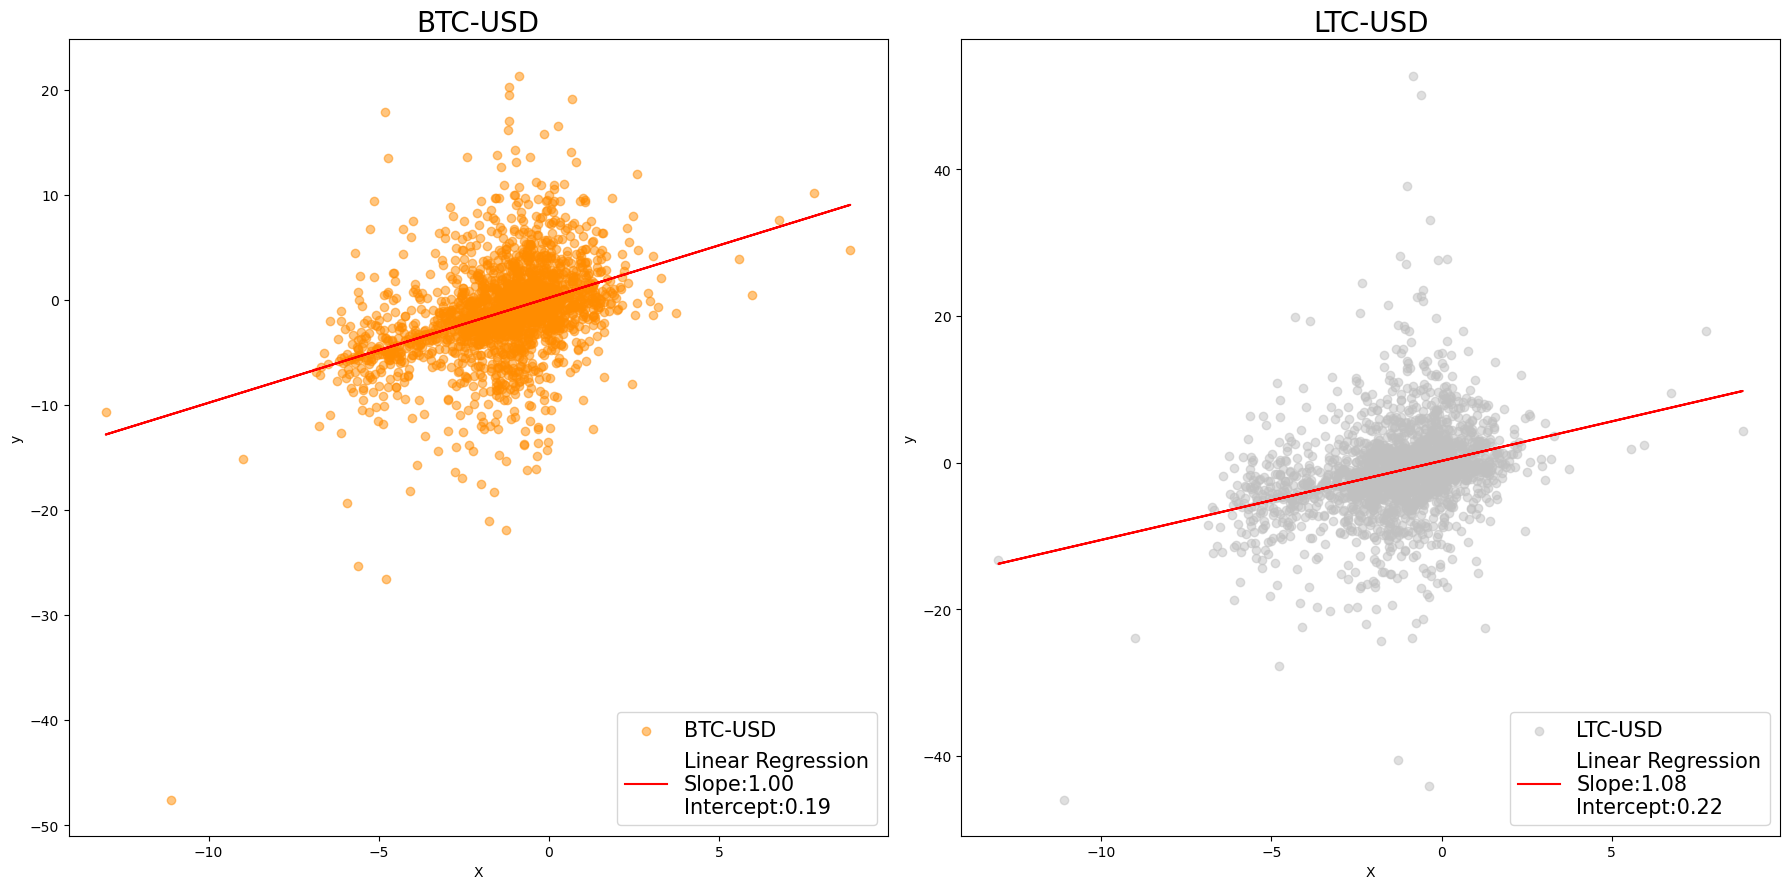

In [12]:
def visualize_models(inst,model,fontsize = 15):   
    Y = model['model_data'][['Y']]
    X = model['model_data'][['X']]
    Y_hat = model['model'].predict(X)
    
    try:
        intercept = model['model'].params['Intercept']
    except:
        intercept = 0
    slope = model['model'].params['X']
    
    plt.scatter(X, Y, label=f'{inst}',alpha = 0.5,color = colour(inst))
    plt.plot(X, Y_hat, color='red', label=f'Linear Regression\nSlope:{slope:.2f}\nIntercept:{intercept:.2f}')
    plt.xlabel('X')
    plt.ylabel('y')
    plt.legend(loc = 'lower right',fontsize = fontsize)
    plt.title(f"{inst}",fontsize = 20)


plots = arrange_plots(visualize_models,fig_size = (18,9))


### Assumptions of Linear Regression

Linear Regression is based on four strong assumptions and one weak assumption. These assumptions are as follows:

1. $E(u_{t}) = 0$
2. $var(u_{t}) = \sigma ^ 2$
3. $cov(u_{i},u_{j}) = 0$
4. $cov(u_{t},x_{t}) = 0$
5. $u_{t} \sim^{i.i.d.} N(0, \sigma ^ 2)$ (weak, not needed to estimate $\hat{\beta_1^{\text{ols}}}$)

If these assumptions are not fulfilled, we cannot assume that our $\hat{\beta^{\text{ols}}}$ is a BLUE estimator. However, if they are satisfied, the OLS estimator has some special properties. These properties include:
1. Linearity: $\hat{\beta^{\text{ols}}}$ can be calcuated using the formula I provided earlier.
2. Unbiased: E[$\hat{\beta^{\text{ols}}}$] = $\beta$.
3. Consistency: $\hat{\beta^{\text{ols}}}$ converges in probability to $\beta$ (converges as n increases).
4. Efficiency: $Var(\hat{\beta^{\text{ols}}}) = \frac{\sigma_u^{2}}{n\sigma_x^{2}}$<br><br>

Note: From these properties we can tell that $\hat{\beta^{\text{ols}}}\sim N(\beta,\frac{\sigma_u^{2}}{n\sigma_x^{2}})$



I will check each of these assumptions with particular focus on if the residuals are normally distributed (5), serially correlated (3) and homo/heteroskedastic (2). I have also plotted the residuals below for reference.

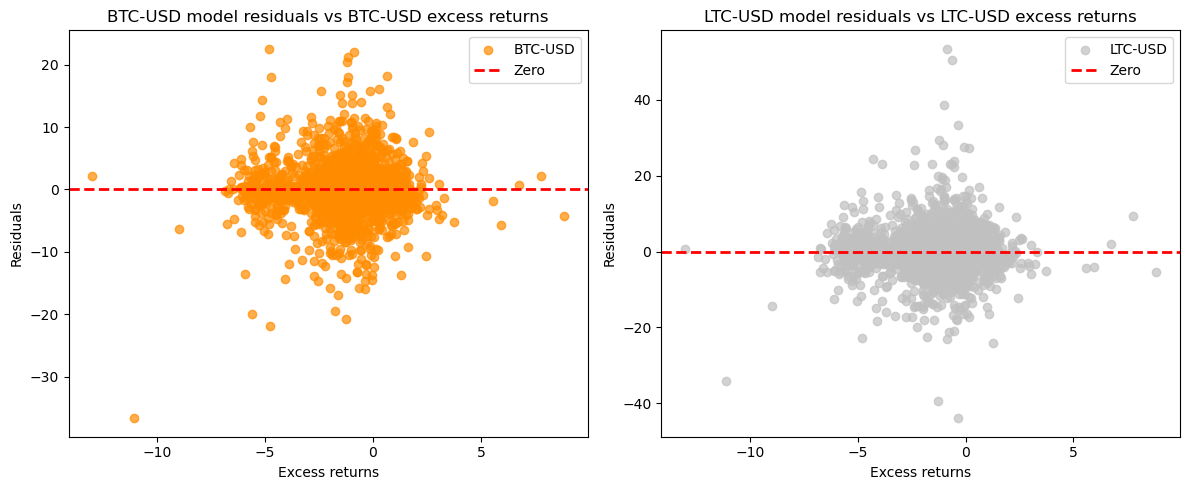

In [13]:
def ind_vs_resid_plot(inst,model):
    X = model['model_data'][['X']]
    Y = model['model'].resid
    residual_std = np.std(Y) #maybe change to var
    
    plt.scatter(X, Y, label=f'{inst}',alpha = 0.7,color = colour(inst))
    plt.axhline(0, color='red', linestyle='dashed', linewidth=2, label='Zero')
    #plt.errorbar(X, Y, yerr=residual_std, linestyle="None", marker="None", color='skyblue', label='Residual Std Dev',alpha = 0.5)
    plt.xlabel('Excess returns')
    plt.ylabel('Residuals')
    plt.legend()
    plt.title(f"{inst} model residuals vs {inst} excess returns")
   
plots = arrange_plots(ind_vs_resid_plot,fig_size = (12,5))
    

#### Zero mean

<b>$E(u_{t}) = 0$

This assumption can easily be checked by seeing if the residuals of each model sum to zero. As you can see from the Python output below, this assumption is satisfied.

In [14]:
for inst,model in models.items():
    sum_resid = abs(sum(model['model'].resid))
    print(f'The sum of the residuals for {inst} is {round(sum_resid,5)}')

The sum of the residuals for BTC-USD is 0.0
The sum of the residuals for LTC-USD is 0.0


#### Homoskedastic

<b>$var(u_{t}) = \sigma ^ 2$

In our model of the form $Y_t = \beta_0 + \beta_1X_t + u_t$, we find that statistical inference about $B_1$ depends on $u_i$. This is because the standard errors of $\hat{\beta}_1$ depend on the distribution of the $u_t$ terms and, as such, depend on the distribution of the residuals $\hat{u}_i$.

If we are looking at the $var(u_{t})$, there are two possible scenarios: homoskedasticity and heteroskedasticity. Homosekedasticty describes the case when $var(u|X = x) = \sigma^2_u$ where $\sigma^2_u$ is a constant. In this case, the variance of the error terms does not depend on X. Heteroskedasticity is the case when $var(u|X = x)$ does depend on X.

Homoskedasticity is essential because the standard error of $\hat{\beta}_1$ is (generally) lower under homoskedasticity. According to the Gauss-Markov Theorem, the OLS estimator has the most downward variance among all linear estimators, but this is only true if the error terms are homoskedastic. For this reason, homoskedasticity is an essential assumption of an OLS model. If a model is found to have heteroskedastic standard errors, this issue can be solved using heteroskedasticity robust common mistakes, which we will see more of in part d.

To check if this condition has been satisfied by my models, I have carried out the following tests:


##### Visually

Looking at the residual plots above, it is hard to say whether there is homoskedasticity or heteroskedasticity. To me, it seems that BTC-USD displays heteroskedasticity while LTC-USD looks homoskedastic. To test this theory, I have carried out several statistical tests.

##### Breusch Pagan

My first statistical test for heteroskedasticity is the "Breusch-Pagan Lagrange Test for Heteroskedasticity". The basic idea of this test is to estimate an auxiliary regression model where the dependent variable is the squared residuals of our original model, and the independent variable is the original dependent variable. This additional model is compared to our original model using a test statistic.

The test statistic is based on the $R^2$ value from the auxiliary model. This test statistic has a chi-squared distribution with K degrees of freedom (K=# of independent variables). Using the test statistic, we carry out the following hypothesis test:

$H_0: var(u|X = x) = \sigma^2_u$ <br>
$H_0: var(u|X = x)$ is dependant on X


In [15]:
def breusch_pagan(models):
    breusch_pagan_names = ['Breush-Pagan Lagrange Multiplier Statistic', 'p-value',
'f-value', 'f p-value']

    for inst,model in models.items():
        test = sms.het_breuschpagan(model['model'].resid, model['model'].model.exog)
        print('\n')
        for  name,result in zip(breusch_pagan_names,test):       
            print(f'{name} for {inst} is {result}')
            
breusch_pagan(models)



Breush-Pagan Lagrange Multiplier Statistic for BTC-USD is 14.752503329384188
p-value for BTC-USD is 0.0001225846641067258
f-value for BTC-USD is 14.847363576600094
f p-value for BTC-USD is 0.00012025319648599072


Breush-Pagan Lagrange Multiplier Statistic for LTC-USD is 0.5880500152203885
p-value for LTC-USD is 0.44317415790001424
f-value for LTC-USD is 0.5876343287065263
f p-value for LTC-USD is 0.44342602163453515


Above, you can see the test statistic and p-value (probability of getting a value more extreme than our test statistic) of the test for each crypto model. Like with any other hypothesis test, if we find a p-value less than our significance level, we reject the null hypothesis in favour of the alternative. As you can see above, the p-value for BTC-USD is significant ($\text{***}$). Therefore, we leave the null hypothesis in favour of the option (there is heteroskedasticity). In contrast, LTC-USD is not statistically significant; we fail to reject the null hypothesis of LTC display homoskedasticity. However, the "Breusch-Pagan Lagrange Test for Heteroskedasticity" does have some drawbacks. This test makes some assumptions about the specific form of Heteroskedasticity that may be present based on the squared residuals. This means that it does not capture all possible forms of heteroskedasticity that may be present in the models. To carry out a test without making assumptions about the type of heteroskedasticity, I have carried out a similar test called the "White's Lagrange Multiplier Test for Heteroskedasticity". White's test does not assume any specific form but tests for all types of Heteroskedasticity.

##### White test

The basic idea of "White's Lagrange Multiplier Test for Heteroskedasticity" is to compare two regression models. Our original model is compared with a more robust model generated by adding additional independent variables derived from the original model's residuals.

The test then generates a test statistic based on the difference in goodness of fit between the two models (if our original model has heteroskedasticity, then the robust model will outperform in explaining variation in our dependent variable). This test statistic has a chi-squared distribution. Using the test statistic, we carry out the following hypothesis test:

$H_0: var(u|X = x) = \sigma^2_u$ <br>
$H_0: var(u|X = x)$ is dependant on X


In [16]:
def white(models):
    white_names = ['White Lagrange Multiplier Statistic', 'p-value','f-statistic', 'f p-value']

    for inst,model in models.items():
        test = sms.het_white(model['model'].resid, model['model'].model.exog)
        print('\n')
        for  name,result in zip(white_names,test):       
            print(f'{name} for {inst} is {result}')
            
white(models)



White Lagrange Multiplier Statistic for BTC-USD is 47.741558441570696
p-value for BTC-USD is 4.295881625104286e-11
f-statistic for BTC-USD is 24.418407084248962
f p-value for BTC-USD is 3.333809615049282e-11


White Lagrange Multiplier Statistic for LTC-USD is 1.390398196148516
p-value for LTC-USD is 0.4989750931146406
f-statistic for LTC-USD is 0.6946386511439777
f p-value for LTC-USD is 0.4993755319257678


Above, you can see the test statistic and p-value of the test for each crypto model. Once again, the test statistic for BTC-USD is statistically significant ($\text{***}$), while for LTC-USD, it is not the same conclusions as the Breush-Pagan test have been reached.
Given that we have expanded our search for Heteroskedasticity to all forms rather than just a specific form, I am now more satisfied that Heteroskedasticity is present in our BTC-USD model residuals but not for LTC-USD. However, I will carry out one further test before making my conclusion.


##### Goldfeld - Quandt Test

My final test is the "Goldfled-Quandt Test". This test checks for heteroskedasticity by explicitly checking the variance of the error terms at different independent variable levels. The test works as follows:

1. The data is partitioned into two subsets 
2. Separate regression models are fitted for each subset, and the residuals of each are calculated.
3. An F-test is performed to compare the variance of the residuals between the two samples.

This test is carried out under a new null and alternative hypothesis:

$H_{0}$: Variances of errors are equal in 2 subsamples $\sigma_{1} ^ 2$ = $\sigma_{2} ^ 2$

$H_{1}$: Variances of errors are not equal in 2 subsamples

If there is a statistically significant change in variance between the samples (across the independent variable), we will get a p-value less than 0.05 and reject our null hypothesis.


In [71]:
def goldfeldquandt(models):
    goldfeldquandt_names = ['F-statistic', 'p-value']

    for inst,model in models.items():
        test = sms.het_goldfeldquandt(model['model'].resid, model['model'].model.exog,split = 0.5,alternative = 'two-sided')
        print('\n')
        for  name,result in zip(goldfeldquandt_names,test):       
            print(f'{name} for {inst} is {result}')
            
goldfeldquandt(models)

#see tsheet for descrption and usage, maybe try for different split values



F-statistic for BTC-USD is 0.7298221652597687
p-value for BTC-USD is 7.015641820443285e-07


F-statistic for LTC-USD is 0.7059503460754044
p-value for LTC-USD is 4.1992536887704374e-08


As you can see from the results above, the test statistics for both BTC-USD and LTC-USD are statistically significant ($\text{***}$) when we have set our split factor to 0.5. A split factor 0.5 splits the data in half when generating the two samples. This is in line with what I expected for LTC-USD; however, this result for BTC-USD suggests that the residuals are homoskedastic when the previous two tests found them to be heteroskedastic. To examine the results of this test for different values of split, I have carried out the following simulation.

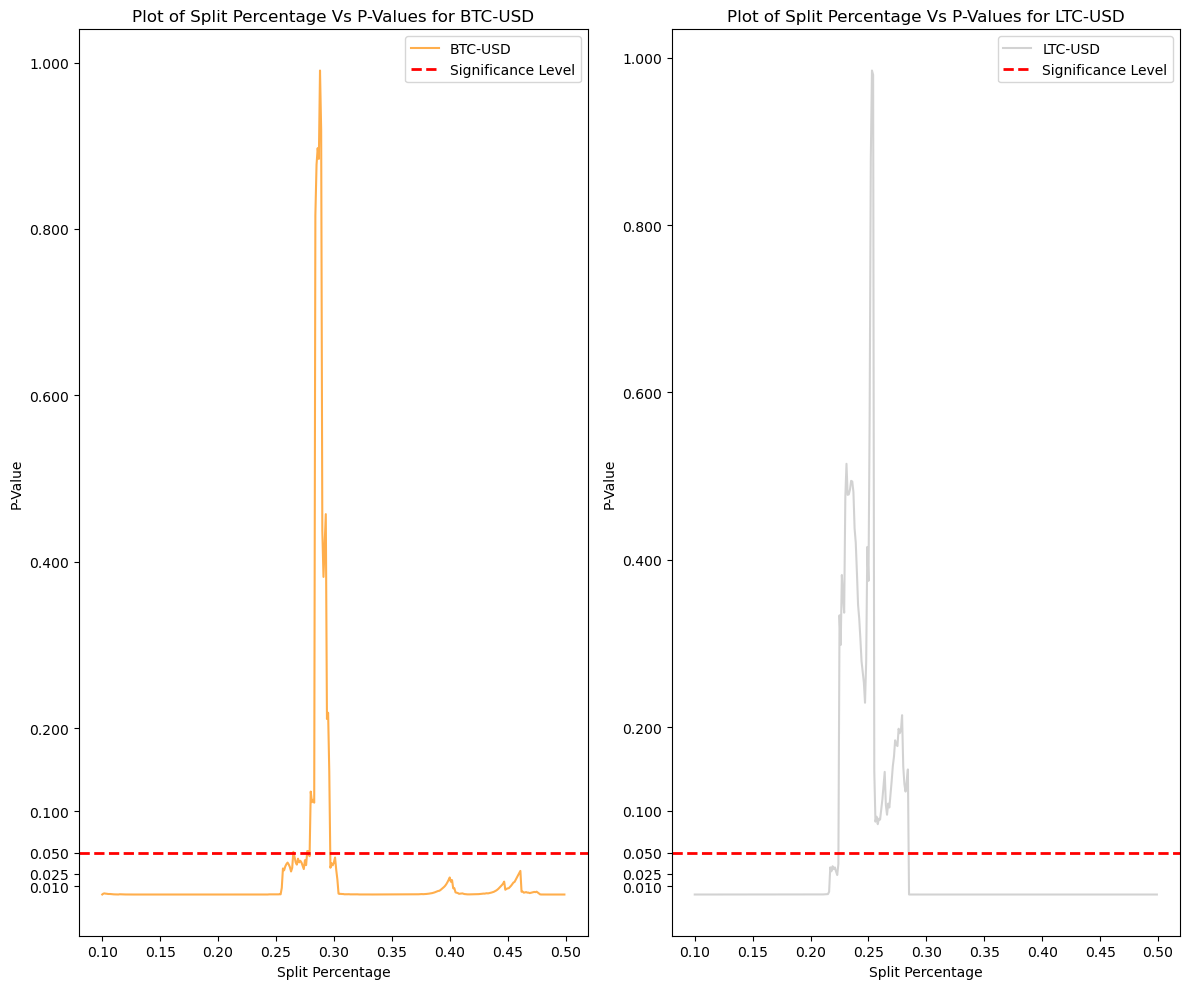

In [72]:
def simulate_gq_test(residuals, x_values):


    split_points = np.arange(0.1, 0.5, 0.001)

    test_statistics = []
    p_values = []


    for split_point in split_points:

        result = sms.het_goldfeldquandt(residuals, x_values, split=split_point,alternative = 'two-sided')
        
        test_statistics.append(result[0])
        p_values.append(result[1])


    return split_points, test_statistics, p_values

def generate_plots(inst,model):
    split_points,test_statistics,p_values = simulate_gq_test(model['model'].resid,model['model'].model.exog)
    plt.plot(split_points,p_values,label=f'{inst}',alpha = 0.7,color = colour(inst))
    plt.axhline(0.05, color='red', linestyle='dashed', linewidth=2, label='Significance Level')
    plt.yticks([0.01,0.025,0.05,0.1,0.2,0.4,0.6,0.8,1])
    plt.xlabel("Split Percentage")
    plt.ylabel("P-Value")
    plt.title(f"Plot of Split Percentage Vs P-Values for {inst}")
    plt.legend()
    
          
plots = arrange_plots(generate_plots,fig_size = (12,10))

As you can see, this simulation has produced some interesting results for both models. This test suggests that almost all split percentages for both models would reject the null hypothesis that the subsamples of residuals. However, if you take a split percentage between 0.25 and 0.3 for BTC-USD and between 0.22 and 0.28 for LTC-USD, you would fail to reject the null hypothesis that the residuals in the two samples have the same variance. 

This test suggests some uncertainty around my previous findings that the LTC-USD model residuals were homoskedastic. The hetero/homoskedasticty of the residuals for both models seems to depend on the subset of the sample data you are looking at.

Given the varying conclusions of my tests, it does not seem correct to conclude that the homoskedasticty assumption of linear regression is fulfilled. Therefore we cannot accruately estimate $\hat{\beta_1^{\text{ols}}}$. To correct this issue, I would suggest using Heteroskedastic robust standard errors (I will examine these further in part d).



#### No Serial Correlation

<b>$cov(u_{i},u_{j}) = 0$

Serial correlation refers to various forms of correlation or dependencies between observations in our data. The most common form of serial correlation is autocorrelation.

Autocorrelation is a measure of the linear relationship that may be present between an observation or data point and a previous or lagged value in a time series. To test for these factors, I have carried out the following tests.

##### Visually

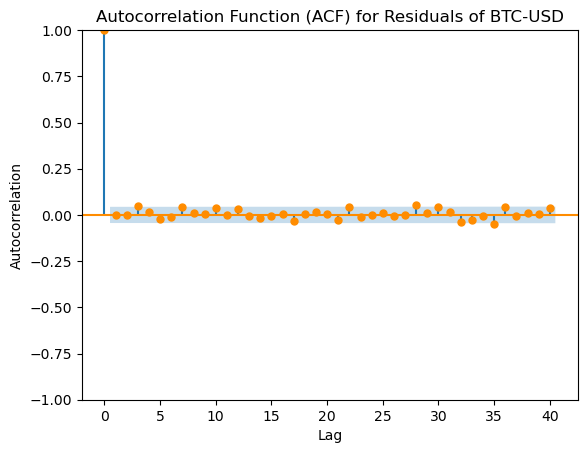

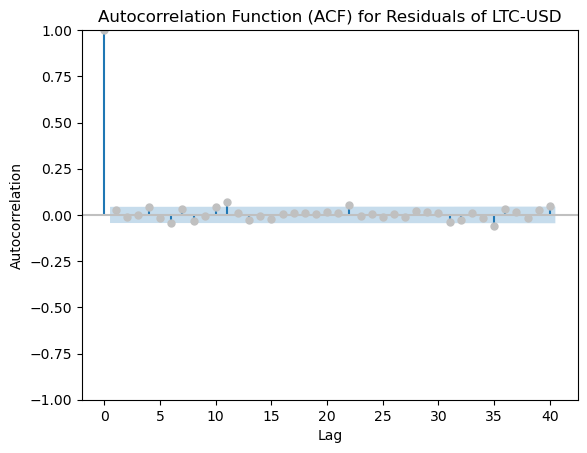

In [19]:
def plot_autocorrelation(inst,model):
    residuals = model['model'].resid
    tsaplots.plot_acf(residuals, lags=40,color = colour(inst))
    plt.title(f'Autocorrelation Function (ACF) for Residuals of {inst}')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')

for inst,model in models.items():
    plot_autocorrelation(inst,model) 
    


At first glance there does not seem to be any significant serial correlation between a lag of 1 and 40. As expected ACF plot for both models quickly fall close to zero due to the time series being stationary. This is a result of using logs as well as differencing and a linear regression in order to derive the residuals. In order to examine this further I have carried out the following statistical test.

##### Durbin-Watson

The first statistical test I will use to check for autocorrelation in the residuals is the "Durbin-Watson Test".

The Durbin-Watson test is used to check if there is a linear relationship between the residuals of my models (autocorrelation). This test looks at first-order autocorrelation, meaning it fits if there is a linear relationship between each residual ($u_t$) and the previous one ($u_t$). This is the same as checking if $\rho$ in the below equation differs from zero. If it is, then there is evidence of a linear relationship

$u_{t} = \rho u_{t-1} + v_{t}$ (random component)  (this is an autoregressive process of order one)

So, in this test, we aim to test the following:

$H_{0}: \rho = 0$

$H_{1}: \rho ≠ 0$

A test statistic must be calculated to summarise this effect across all residuals. This is done using the following equation :

$d = \frac{\sum_{i=2}^{n} (e_i - e_{i-1})^2}{\sum_{i=1}^{n} e_i^2}$



In [20]:
def durbin_watson(models):
    for inst,model in models.items():
        resid = model['model'].resid
        print(f'Durbin-Watson Statistic for {inst} is {sms.durbin_watson(resid)}')

durbin_watson(models)

Durbin-Watson Statistic for BTC-USD is 2.0046890545043876
Durbin-Watson Statistic for LTC-USD is 1.9511637336197878


<br>The interpretation of the values for the Durbin-Watson Statistic depend on where the statitic lies on the following diagram.

<div style="position: relative;">
    <div style="border: 1px solid #000; width: 100%; height: 2px; position: absolute; top: 50%; transform: translateY(-50%);"></div>
    <div style="position: absolute; left: 0%;">0</div>
    <div style="position: absolute; right: 0%;">4</div>
    <div style="position: absolute; left: 20%;">$d_l$</div>
    <div style="position: absolute; left: 40%;">$d_u$</div>
    <div style="position: absolute; left: 50%;">2</div>
    <div style="position: absolute; left: 60%;">$4-d_u$</div>
    <div style="position: absolute; left: 80%;">$4-d_l$</div>
</div>
<br>
 $\hspace{1cm}$Postive Correlation $\hspace{2cm}$ Inconclusive Area $\hspace{2.5cm}$ No Correlation $\hspace{2.5cm}$ Inconclusive Area $\hspace{2cm}$ Negative Correlation

In order to find the values for $d_l$ and $d_u$, I have used the Durbin Watson Tables. For our data we have 2000 observations however this table only goes up to 200 so that is what I have used. So for k = 2 (#parameters) and 200 observations the tables have $d_l$ = 1.653 and $d_u$ = 1.693.

So as you can see from the results, for both models I conclude that there is no first order serial correlation between the residuals.

To thoroughly check for autocorrelation, I must look beyond first-order tests. Rather than examining autocorrelation of the form $u_{t} = \rho u_{t-1} + v_{t}$ (random component)  (between one data point and the previous one), it is advantageous to check for autocorrelation at a variety of lags. 

$u_{t} = \rho_{1} u_{t-1} + \rho_{2} u_{t-2} + \rho_{3} u_{t-3} + ... + \rho_{r} u_{t-r} + v_{t}$ auxiliary regression.

I will do this using the Breusch Godfrey test.


##### Breusch Godfrey Test

The Breusch Godfrey test is similar to the Durbin-Watson test, however it extends the test for autocorrelation in the residuals to higher orders.

This test works by including a number (as chosen by the user) of lagged values of the residuals as additional independant variables to the model described by the Durbin-Watson model and recalculating the model in order to check the statistical significance of the coefficients:

$u_{t} = \rho_{1} u_{t-1} + \rho_{2} u_{t-2} + \rho_{3} u_{t-3} + ... + \rho_{r} u_{t-r} + v_{t}$ auxiliary regression

$H_{0}: \rho_{1} = 0$ and $\rho_{2} = 0$ and ... and $\rho_{r} = 0$

$H_{1}: \rho_{1} ≠ 0$ and $\rho_{2} ≠ 0$ and ... and $\rho_{r} ≠ 0$


This summaries the autocorrelation between $u_{t}$ and the previous (lagged) n terms

In [75]:
def breusch_godfrey(models):
    breusch_godfrey_names = ['Breusch Godfrey Lagrange Multiplier Statistic','p-value','f-value','f p-value']

    for inst,model in models.items():
        test = sms.acorr_breusch_godfrey(model['model'],nlags = 12)
        print('\n')
        for  name,result in zip(breusch_godfrey_names,test):       
            print(f'{name} for {inst} is {result}')

breusch_godfrey(models)




Breusch Godfrey Lagrange Multiplier Statistic for BTC-USD is 14.556233478088304
p-value for BTC-USD is 0.26660585978943635
f-value for BTC-USD is 1.2133596335482422
f p-value for BTC-USD is 0.26734508940494817


Breusch Godfrey Lagrange Multiplier Statistic for LTC-USD is 27.64537800569236
p-value for LTC-USD is 0.006231889306760221
f-value for LTC-USD is 2.3197359733726297
f p-value for LTC-USD is 0.0060924459297146275


As you can see from the results I fail to reject the null hypothesis for BTC-USD at a 1%,5% and 10% significance level. Hence, I fail to reject the null hypothesis that there is no serial correlation of any degree among the residuals. However, for LTC-USD I fail to reject the null hypothesis at a 1% and 5% significance level but at a 10% significance level I would reject the null and conclude that there is serial correlation of higher order. So although is is highly likely that overall there is no serial correlation of any degree it may still be useful to use serial correlation robust standard errors in the future to protect our estimation of $\hat{\beta_1^{\text{ols}}}$

#### Normality

<b>$u_{t}: N(0, \sigma ^ 2)$


##### Visually

I have generated the plots below to check if the residuals are normally distributed.

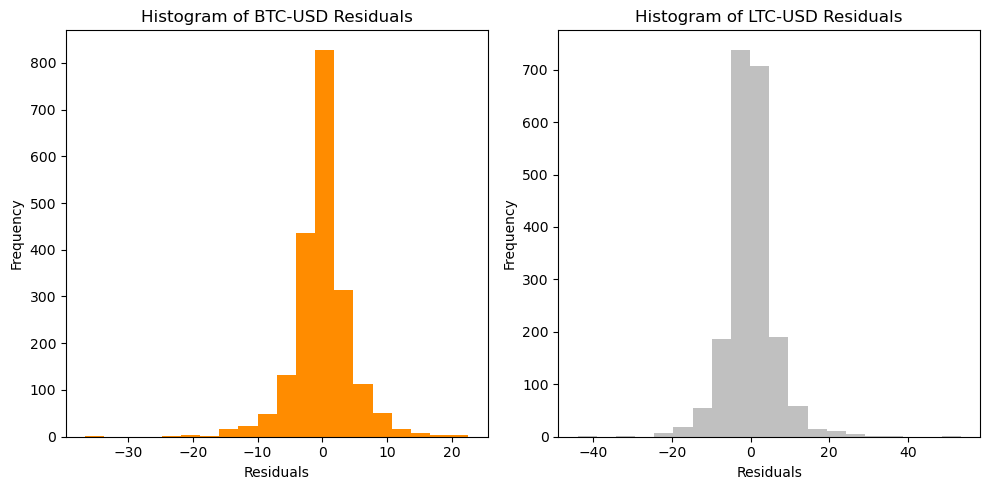

In [22]:
def visualize_residuals(inst,model):
    plt.hist(model['model'].resid, bins=20,color = colour(inst))
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.title(f"Histogram of {inst} Residuals")
    
    
plots = arrange_plots(visualize_residuals)

At first glance, it does seem that the residuals appear to follow a normal distribution centred around zero. To examine this further, checking if the plot is skewed and leptokurtic is helpful. We say our data is skewed if it is not symmetric around the mean. This would be the case if the tail of the distribution extended further on one side or if more of the data was present on either side of the mean. We say our distribution is leptokurtic if it has a higher peak and heavier tail than a normal distribution. To check for these properties in the residual distribution for both crypto models, I have overlayed a density function and a normal distribution with the same mean and variance as the residuals.

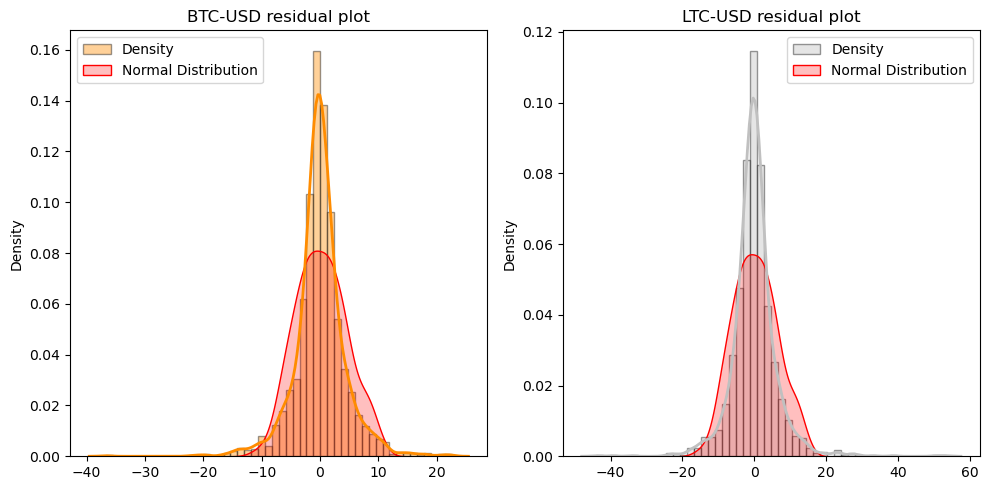

In [23]:
def resid_plot(inst,model):
    resid = model['model'].resid
    sns.distplot(resid,hist=True, kde=True, color=colour(inst),hist_kws={'edgecolor':'black'},\
            kde_kws={'linewidth': 2}, label = 'Density')

    np.random.seed(0)
    normal_sample = np.random.normal(np.mean(resid),np.std(resid), 249)
    sns.kdeplot(normal_sample,kernel='gau',color = 'red',shade=True,label = 'Normal Distribution')
    plt.title(f'{inst} residual plot')
    plt.legend()
    
    
plots = arrange_plots(resid_plot)

Skew:<br>
The BTC-USD residuals seem to have a fatter tail to the left of 0, while LTC-USD appears to have a fatter tail to the right of 0. So, there does seem to be some skewness. However, I will examine this further in statistical tests.

Kurtosis:<br>
It is clear from the plots that both of our model residuals are leptokurtic. Note that the respective density plots have higher peaks and heavier tails than the normal distribution with the same mean and variance.

Shew and Kurtosis can also be summarised and tested using statistical tests. Below, I have used the Jargue Bera test to back up my beliefs after seeing the visualisations.


##### Jarque-Bera

The Jarque Bera test tests whether the coefficient of skewness and coefficient of excess kurtosis are jointly zero. 

$H_{0}$: residuals are normally distributed (distribution is symmetric and mesokurtic)

$H_{1}$: residuals are not normally distributed

The test statistic is calculated using the sample skewness (S) and the sample excess kurtosis (K) as defined as follows:

$JB = \frac{n}{6} \left(S^2 + \frac{1}{4}(K - 3)^2\right)$<br><br>
$S = \frac{E[u^3]}{(\sigma^2)^{3/2}}$<br>
$K = \frac{E[u^4]}{(\sigma^2)^{2}}$<br>

The test statistic follows a chi-squared distribution with two degrees of freedom; a p-value can be calculated using this fact.


In [24]:
def jarquebera(models):
    jarquebera_names = ['Jarque-Bera', 'P-Value', 'Skewness', 'Kurtosis']
    for inst,model in models.items():
        resid = model['model'].resid

        test = sms.jarque_bera(resid)
        print('\n')
        for  name,result in zip(jarquebera_names,test):       
            print(f'{name} for {inst} is {result}')


jarquebera(models)




Jarque-Bera for BTC-USD is 2955.786766001033
P-Value for BTC-USD is 0.0
Skewness for BTC-USD is -0.1911952970698037
Kurtosis for BTC-USD is 8.946320170631926


Jarque-Bera for LTC-USD is 9028.998628056415
P-Value for LTC-USD is 0.0
Skewness for LTC-USD is 0.6629617172394001
Kurtosis for LTC-USD is 13.329490162759901


As you can see from the results, the test statistic is statistically significant ($\text{***}$) for both models. Therefore, I reject the null hypothesis in favour of the alternative view. So, I conclude that my beliefs from the visualisations were correct; there is enough kurtosis and skew to conclude with statistical significance that the residuals are not normally distributed.

To conclude, my tests and visualizations have shown that with statistical significnce ($\text{***}$) the residuals for both models are not normally distributed. This means that 5. $u_{t} \sim^{i.i.d.} N(0, \sigma ^ 2)$ is not fulfilled by the models. While this assumption is not neccessary to estimate $\hat{\beta_1^{\text{ols}}}$ it does mean that its sampling distribution of  $\hat{\beta_1^{\text{ols}}}$ may not be normally distributed.

To conclude my analysis of the model residuals, I have found the following results.

1.The zero mean assumption of linear regression has been fulfilled.
2.I was not able to conclude with statistical significance that the residuals for both models are Homoskedastic. From the Breusch Pagan and White test, I found that the residuals for BTC-USD are heteroskedastic but the LTC-USD residuals are homosekdastic. However the results of the Goldfeld-Quandt test displayed that there is differing varience across subsets of the residual data for both models. As such in order to correctly estimate $\hat{\beta_1^{\text{ols}}}$, heteroskedasticity robust standard errors should be used
3.I concluded with statistical significance ($\text{***}$) that there is no first order serial correlation between residuals for either of the models. I also concluded that with statistical significance ($\text{***}$ for BTC-USD and $\text{**}$ for LTC-USD) there is no higher order serial correlation among the model residuals of both models.
4.Finally I concluded that with statistical significance ($\text{***}$ the residuals for each model are not normally distributed. This does not affect the estimation of $\hat{\beta_1^{\text{ols}}}$ but it does mean that its sampling distribution may not be normally distributed. 


---
# Question D

When Heteroskedastity is found in a model's residuals, carrying out analysis using standard errors under homoskedastic assumptions would lead to incorrect results. To solve this issue, heteroskedasticity robust standard errors must be used. See the formulae for both below to see how they differ.

$SE(\hat{\beta_1}) = \frac{\sigma_u}{\sqrt{n}\sigma_x}$

$SE(\hat{\beta_1}^{\text{robust}}) = \sqrt{\frac{1}{n-2} \sum_{i=1}^{n}(X_i-\mu_X)^{2} \hat{u_i^{2}} \cdot \frac{1}{n\text{Var}(X_i)^{2}}}$

Where:<br>
$\sigma_u$ is the square root of the varience of the residuals<br>
$\sigma_X$ is the varience in the independant variable<br>
$\mu_X$ is the mean of the the indepedant variable<br>
$\hat{u_i}$ is the $i^{th}$ error term<br>

So as you can see the robust standard error forumla is much more complex and difficult to work with. However in order to correctly estimate $\hat{\beta_1}^{ols}$ it is essential to use them.

Given that the residuals of the LTC-USD and BTC-USD models are homoskedastic and heteroskesatic, respectively, comparing the impact robust standard errors have on both models will be interesting. I have recalculated both models and presented the new outputs above the original outputs.

Note: I have also used autocorrelation robust standard errors to remove the autocorrelation spotted in the LTC-USD model residuals.


## New Models vs Old Models

In [25]:
robust_models = {f'{inst} Robust':generate_model(inst,'HAC') for inst in inst_data.keys()}

In [26]:
standard_htmls = []  
for inst,model in models.items():
     html = f"<h2>Linear Regression Summary for {inst}</h2>{model['model'].summary().as_html()}"   
     standard_htmls.append(html)
        
display_html_side_by_side(standard_htmls)

robust_htmls = []  
for inst,model in robust_models.items():
     html = f"<h2>Linear Regression Summary for {inst}</h2>{model['model'].summary().as_html()}"   
     robust_htmls.append(html)
display_html_side_by_side(robust_htmls)


As you can see, switching to the robust standard errors has not impacted the coefficient estimates. As a result, there has been no change in values of goodness of fit measures such as the $R^2$, AIC, and BIC. There is also no change in the normality of residual tests such as the Jarque-Bera statistic, Omnibus, Skew and Kurtosis. This is expected as $SE(\hat{\beta}_1)$ isn't an input to these statistics. The main changes are evident in the distributions of the coefficients.

### Coefficients

In [28]:
standard_htmls = []  
for inst,model in models.items():
     html = f"<h4>Coefficient Summary for {inst}</h2>{model['model'].summary().tables[1].as_html()}"   
     standard_htmls.append(html)
        
display_html_side_by_side(standard_htmls)

robust_htmls = []  
for inst,model in robust_models.items():
     html = f"<h4>Coefficient Summary for {inst}</h2>{model['model'].summary().tables[1].as_html()}"   
     robust_htmls.append(html)
display_html_side_by_side(robust_htmls)

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1940,0.120,1.615,0.106,-0.042,0.430
X,1.0000,0.053,18.886,0.000,0.896,1.104
,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.2169,0.170,1.274,0.203,-0.117,0.551
X,1.0791,0.075,14.380,0.000,0.932,1.226


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,0.1940,0.126,1.536,0.125,-0.054,0.442
X,1.0000,0.068,14.671,0.000,0.866,1.134
,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,0.2169,0.180,1.206,0.228,-0.136,0.570
X,1.0791,0.085,12.743,0.000,0.913,1.245


### Comparison

1. Coefficients:
There is no change in the regression coefficients when using robust standard errors. This is because a change in the standard errors of a distribution does not change the value which the distribution is centered around
2. Standard Errors:
There is an increase in the standard errors for both $\hat{\beta}_1$ and $\hat{\beta}_0$. The robust standard errors are larger than the non-robust. This is because the robust standard errors provide a more conservative estimate with a larger margin for error around the coefficient estimates.
3. Test Statistic:
In both cases, the test statistic is given by the coefficient divided by the standard error. However, the test statistics have different distributions. Under non-robust, we have a t-statistic with a t-student distribution with n-k degrees of freedom (n = # of observations, k = # of coefficients). However, we have a normally distributed z statistic under robust standard errors. In the robust case, the value of the test statistic will be smaller due to the coefficient being divided by a larger standard error.
4. P-Value:
Given that we have a smaller test statistic, we get larger p-values as it is more likely to get extreme values greater than our test statistic. The different distributions do not have much impact on this as, with such a large number of observations, the t-student and normal distributions converge.
5. Confidence Interval:
Given that a confidence interval around the coefficient estimates is calculated using $CI_{1-\alpha}^{\beta_1} = [\hat{\beta_1}\pm Z_{\frac{\alpha}{2}}*SE(\hat(\beta_1))]$ it is clear that we will get wider intervals under the same level of significance due to the larger standard errors.

I have generated the plots below to visualise the difference in distributions for the coefficients.


## Sample Distributions

In [29]:
def B1_sample_dist_generator(inst,model,alpha = 0.05):
    X = model['model_data']['X']
    y = model['model_data']['Y']
    original_B1 = model['model'].params['X']  
    
    interval = model['model'].conf_int(alpha = alpha)
    
    lower_bound = interval.iloc[1,0]
    upper_bound = interval.iloc[1,1]
    
    num_bootstrap_samples = 1000
    bootstrap_B1 = []

    for i in range(num_bootstrap_samples):
        # Resample with replacement
        data = pd.DataFrame()
        bootstrap_indices = np.random.choice(len(X), len(X), replace=True)
        data['X'] = X[bootstrap_indices]
        data['Y'] = y[bootstrap_indices]
        
        
        # Fit a linear regression model to the bootstrap sample
        new_model = smf.ols(formula = 'Y~X', data = data).fit()
        bootstrap_B1.append(new_model.params['X'])
    
    

    
    
    # Visualize the sampling distribution
    plt.hist(bootstrap_B1, bins=30, edgecolor='k',color = colour(inst))
    plt.axvline(original_B1, color='red', linestyle='dashed', linewidth=2, label='Original B1')
    plt.axvline(lower_bound, color='green', linestyle='dashed', linewidth=2, label='Lower Bound')
    plt.axvline(upper_bound, color='green', linestyle='dashed', linewidth=2, label='Upper Bound')
    plt.xlabel('B1 Coefficient')
    plt.ylabel('Frequency')
    plt.title(f'Sampling Distribution of B1 for {inst}')
    plt.legend()
   
    


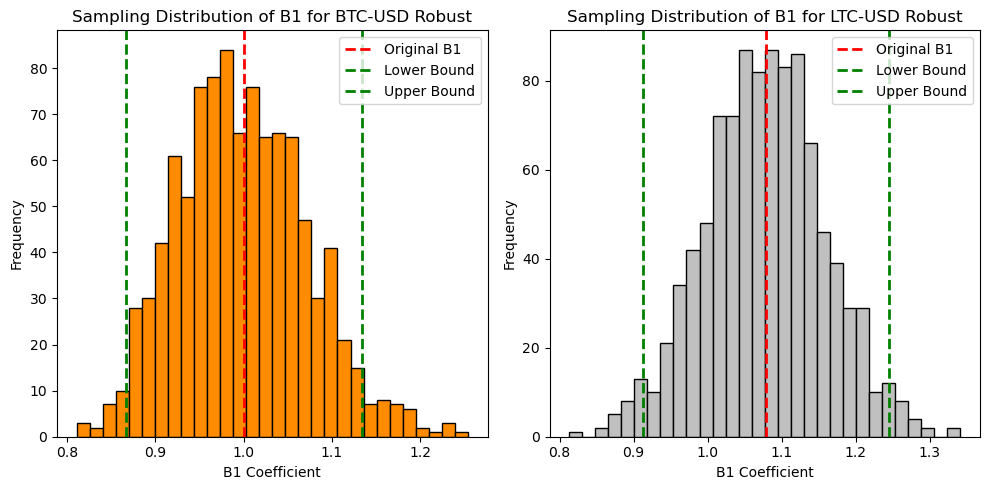

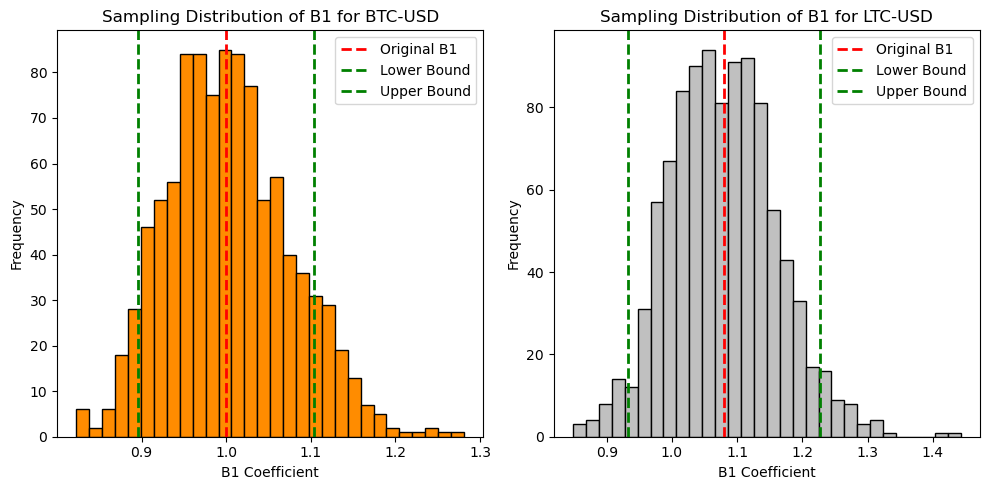

{'BTC-USD': None, 'LTC-USD': None}

In [30]:
arrange_plots(B1_sample_dist_generator,models = robust_models)
arrange_plots(B1_sample_dist_generator)

As you can see from the plots, the mean has remained the same, but the bounds are much wider around the mean in the robust case. This is consistent with my findings above.

To summarise, the main impact of using standard errors is a wider standard error. While this leads to wider confidence intervals, rectifying the breaking of the homoskedasticty assumption of linear regression and the Gauss-Markov theorem is essential. Without this, we cannot be confident in our estimation of $\hat{\beta_1}^{ols}$.

---
# Question E

## Confidence Interval

When it comes to the coefficient $\beta_1$ in each of my models, it is nothing more than a Random Variable. Like any other Random Variable, it has a sampling distribution; thus, confidence intervals around the mean of $\beta_1$ can be formed. In this case, I will examine a 95% confidence interval ($\alpha = 0.05$), and to do this, the formula I mentioned in part d is used:<br>
$CI_{1-\alpha}^{\beta_1} = [\hat{\beta_1}\pm Z_{\frac{\alpha}{2}}*SE(\hat(\beta_1))]$<br>
Given my conclusion in part d, that it is better to use robust standard errors, I will analyse the confidence intervals on the robust models. Below, I have presented the coefficient table from the regression summaries, where you can see the confidence intervals on the right-hand side.


In [31]:
display_html_side_by_side(robust_htmls)    

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,0.1940,0.126,1.536,0.125,-0.054,0.442
X,1.0000,0.068,14.671,0.000,0.866,1.134
,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,0.2169,0.180,1.206,0.228,-0.136,0.570
X,1.0791,0.085,12.743,0.000,0.913,1.245


<b>What does a 95% confidence interval mean?</b><br>
If you were to take random draws from the sampling distribution of $\beta_1$ 95% of the time, these realisations would be within the interval 95% confidence interval. I have reproduced the visualisations seen in part d to explore this further.<br><br>
<b>What does it mean if zero is in the 95% confidence interval?</b><br>
If zero is in the 95% confidence interval then at a 5% significance level we can conclude that the coefficient is not statistically significant (different from zero). 


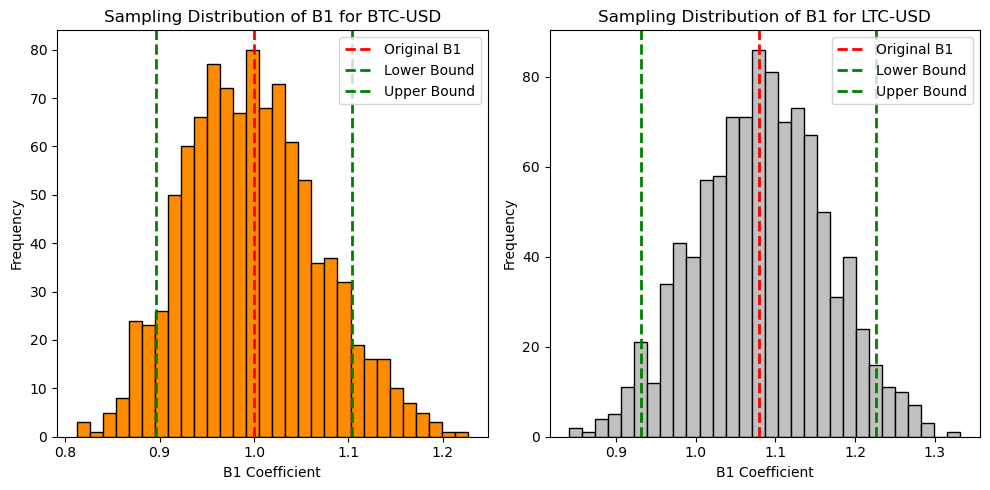

In [32]:
plots = arrange_plots(B1_sample_dist_generator)

I have generated a sampling distribution for $\beta_1$ for both BTC-USD and LTC-USD. I did this by randomly resampling the original dataset 1000 times and generating new values of $\beta_1$. One interesting thing to notice is that these sampling distributions resemble a normal distribution centred around the mean $\hat{\beta_1}$. This is thanks to the central limit theorem we have:

$\frac{\hat{\beta_1}-E[{\hat{\beta_1}}]}{\sqrt{Var(\hat{\beta_1})}} \sim N(0,1)$


So, for large n, the number of samples increases, and the sampling distribution converges in distribution to a normal distribution. In particular, when the sampling distribution is standardised with its mean and variance, it converges to a standard normal distribution.

As you can see, I have marked three lines on each plot; the central red dashed line is the original realisation of $\hat{\beta_1}$ estimate generated by our OLS model ($\hat{\beta_1^{\text{ols}}}$) and the green lines at either side of that are the upper and lower bounds of the 95% confidence interval. This visualisation is a great way to show the true meaning of a 95% confidence interval.


## Hypothesis Test

<b>Test the hypothesis tests that $\beta_1$ is equal to the $\beta$ of the market ($\beta$ = 1):</b>

For this test, I am carrying out a two-tailed test with the following null and alternative hypotheses:<br>
$H_0$: ${B}_1$ = 1<br>
$H_1$: ${B}_1$ \$\neq\$ 1.

In order to do this a test statistic needs to first be calculated using the following formula:<br>
$T = \frac{\hat{\beta_1}-1}{\sqrt{SE({\hat{\beta_1}})}}$<br>
The test statistic quantifies the degree of difference between \$\hat{\beta}_1\$ and the value we are testing against (1). Once this test statistic has been calculated, I can use it to test the null hypothesis. This can be done by defining a rejection region for the test statistic using our significance level; however, I decided to do this by calculating a p-value.

The p-value of a hypothesis test represents the probability of observing a test statistic that is more extreme than the one calculated from the sample data, assuming the null hypothesis is true. As this is a two-sided hypothesis test, we are checking if $\beta_1$ is equal to or not equal to some value.
To calculate the p-value of this test, we need to assume the distribution of the test statistic. In this case, I have used a t-distribution (with n-1 degrees of freedom). Generally, a t-distribution is assumed when you have a small sample; however, it is also frequently used for hypothesis testing with large samples like we are dealing with. This is because, for large n, the t-distribution converges to a normal distribution.
Given that I am using a t-distribution, the p-value can be calculated as $P(T>|t|)$; this is the probability of getting a value from a t-distribution more extreme (higher or lower) than our test statistic.
If our p-value is less than our significance level (0.05), we reject the null hypothesis. I have done this process using Python; the results are printed below.


In [33]:
def hypothesis_test(inst,model,H0,alpha):
    degrees_freedom = model['model'].df_resid 
    t_statistic = (model['model'].params[1] - H0) / model['model'].bse['X']
    p_value = 2 * (1 - stats.t.cdf(abs(t_statistic), degrees_freedom))
    if p_value < alpha:
        print(f"For {inst}: the p-value ({p_value}) for is less than alpha ({alpha}), reject the null hypothesis.")
    else:
        print(f"For {inst}: the p-value ({p_value}) is greater than alpha ({alpha}), fail to reject the null hypothesis.")
        
output = [hypothesis_test(inst,model,1,0.05) for (inst,model) in models.items()]

For BTC-USD: the p-value (0.9998141441931108) is greater than alpha (0.05), fail to reject the null hypothesis.
For LTC-USD: the p-value (0.2921202882854421) is greater than alpha (0.05), fail to reject the null hypothesis.


From the results you can see that for both BTC-USD and LTC-USD we fail to reject the null hypothesis and conclude that both crypto's have the same $\beta_1$ as the market.

### Do your results match your beliefs about risky and safe returns?

Safe Returns
In my view, safe returns are typically characterised by predictable cash flows and high capital preservation. As such, these low-risk assets tend to have low returns but also low variance in returns. Examples of assets like this include US T-Bills and High-Quality Corporate Bonds. The safety of these assets results from their cash flows being backed by governments and corporations with low credit risk.

Moderately Risky Returns
Index funds such as the S&P 500 and the NASDAQ tend to be characterised as moderately risky returns. These assets are a portfolio of equities which individually could be classified as risky assets; however, by combining them into a portfolio, the variance of the high cash flows can be netted to produce a lower risk and lower return asset. As such, large funds like these are protected from industry and company-specific volatility, but they are still exposed to macro or overall market volatility. So, in the short term, there is a risk of overall market volatility, which could be driven by factors such as US CPI or Global Conflicts. As the S&P 500 encapsulates such a wide variety of industries, its returns tend to be referred to as the "market returns" as they are a good indicator of the returns and volatility of the global financial markets. This is why we have used the S&P as our indicator for market returns. Other assets, such as individual equities, ETFs, and cryptocurrencies, tend to be compared to the market return to indicate how risky they are relative to the market.

High-Risk Returns
Assets in this category are often associated with a more risky "gamble" than others. They are characterised by high variance in their cash flows, so there is the possibility of huge returns but also very negative returns. Assets in this category include certain stocks and cryptocurrencies like Bitcoin and Litecoin. Historically, cryptocurrencies, in particular, have displayed extremely risky cash flows. They have gone through "Crypto Boom" periods, such as in 2013 when a Bitcoin investor would have achieved a 5507% annual return on their investment. However, there have also been periods of "Crypto Winters", such as 2022, when a Bitcoin investor would have lost 81% on their investment. So, as you can see, investing in cryptocurrencies has enormous potential for both gains and losses.  


How do my results challenge these beliefs?
My model indicates that with statistical significance ($\text{***}$) for every 1% increase in market excess returns, I fail to reject that the excess returns for BTC-USD and LTC-USD also increase by 1%. This result suggests that the excess returns for these high-risk cryptocurrencies move proportionally with the excess returns of the market. This result challenges the consensus beliefs about risky vs safe returns.


So, are my beliefs wrong?
At first glance, it might seem that my beliefs about the cryptos are wrong. However, the quantity of our model must be taken into account. 
As we have seen from the $R^2$ values of the models, the excess returns of the market account for only a tiny fraction of all variation in the excess returns of the cryptos. This effect is visible in the first plot I produced at the start of this project. The story of excess returns for the market and the cryptocurrencies displays the actual difference in the excess returns between them. 
The first reason we may not have captured all of the variance in the crypto excess returns could be because we assumed a linear relationship between excess market returns and excess crypto returns. However, it is possible that a non-linear relationship may be a better fit. Another reason could be that other variables are needed to explain the crypto excess returns fully. In this case, our results would still stand: for every 1% increase in the market excess returns, crypto returns may also increase by 1%, but other factors may drive the rest of the variation that we see in the excess returns plot.
So, to conclude, it may seem that my results challenge my beliefs about risky vs safe returns, but my results just tell part of the story of crypto returns with other chapters yet to be written.


---
# Question F

## Choosing Sub Samples

Given my findings in part e, that the relationship between the market and crypto excess returns may be non-linear or driven by other independent variables, the data may be better fitted by several regression lines around some structural breakpoints. I will split my data into two subsets of 200 observations to examine this idea. To optimally choose two subsets for each crypto of 200 observations from the sample of 2000 observations, I have decided to use the Chow test.

### The Chow Test

The Chow Test tests whether the coefficients in two regression models fitted on two subsets of a larger dataset around some structural breakpoint are equal. The test works as follows:

Suppose we break out the dataset into two subsets around a split point and fit a regression model to each in the form:

$\hat{Y_t} = \hat{\beta_0^{A}} + \hat{\beta_1^{A}}X_t +\hat{u_t}$ <br><br>
$\hat{Y_t} = \hat{\beta_0^{B}} + \hat{\beta_1^{B}}X_t +\hat{u_t}$

Then, the Chow Test has the following null and alternative hypotheses:

$H_0: \hat{\beta_0^{A}} = \hat{\beta_0^{B}} , \hat{\beta_1^{A}} = \hat{\beta_1^{B}}$ <br><br>
$H_A$: At least one of the comparisons in the null hypothesis is not equal


The Chow test statistic is calculated using the following formula.

$F = \frac{{(S_T -(S_1+S_2)) / k}}{{(S_1+S_2)/(N_1+N_2-2k)}}$

where<br>
$S_T$: Sum of squared residuals for the total data<br>
$S_1,S_2$: Sum of squared residuals for each subset<br>
$N_1,N_2$: Number of observations in each group<br>
k: Number of parameters for the models (2 in our case of simple linear regression)<br>

This statistic is F distributed with k and $N_1+N_2-2k$ degrees of freedom.


<b>How to choose the subsets?</b><br>
For each of my cryptos, I developed an algorithm to iterate through all possible split points in the datasets of 2000 observations and gather 200 observations before and after the split. Using the data generated by the algorithm, I calculated a chow statistic for each split point and plotted the results below. 

### Generating Chow Test Simulation

In [34]:
def chow_test(main_model,split_models,alpha = 0.05):
    if len(split_models) == 2:
        model1 = split_models[0]     
        model2 = split_models[1]

        
        n1 = len(model1['model_data'])
        n2 = len(model2['model_data'])
        k = len(model1['model'].params)
        
        critical_value = stats.f.ppf(1-alpha, k, n1 + n2 - 2*k)
        
        ssr0 = (main_model['model'].resid**2).sum()
        ssr1 = (model1['model'].resid**2).sum()
        ssr2 = (model2['model'].resid**2).sum()

        numerator = (ssr0 - (ssr1 + ssr2))/  k
        denominator = (ssr1 + ssr2) / (n1 + n2 - 2*k)
        chow_statistic = numerator / denominator

        p_value = 1 - stats.f.cdf(chow_statistic, k, n1 + n2 - 2*k)
        return chow_statistic,p_value,critical_value
    else:
        print('Error incorrect number of models passed, you must pass an iterable of length 2')


In [35]:

def generate_split_data(dataset,step = 10,sample_size = 200):
    data = []
    for i in range(sample_size,len(dataset)-(sample_size-1),step):
        data_sets = {}
        data_sets['split_point'] = i
        data_sets['total_data'] = dataset[i-sample_size:i+sample_size]
        data_sets['sample1'] = data_sets['total_data'][:sample_size]
        data_sets['sample2'] = data_sets['total_data'][sample_size:]
        data_sets['split_date'] = dataset.loc[i,'date']
        data.append(data_sets)
    return data




40.0% of the chow statistics generated for BTC-USD are greater than the critical value 3.018509658418929
33.75% of the chow statistics generated for LTC-USD are greater than the critical value 3.018509658418929


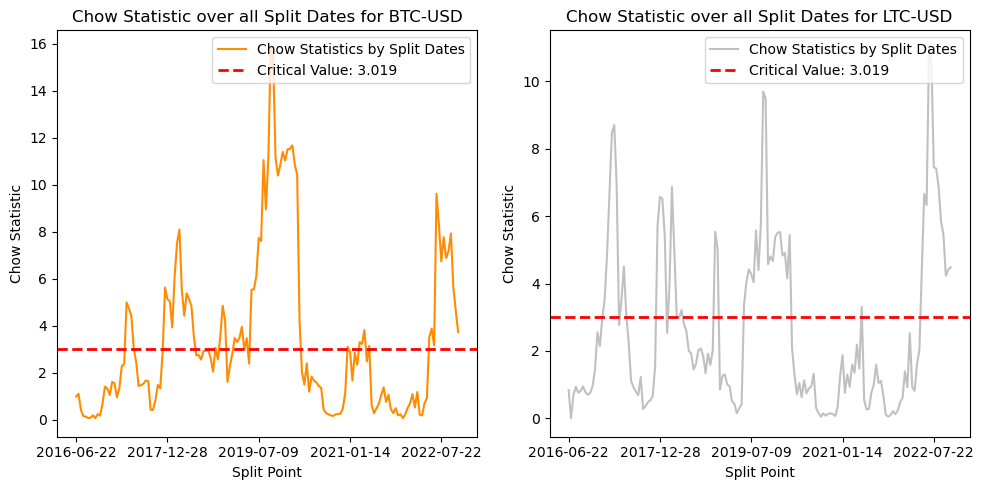

The split date for BTC-USD with the highest chow statistic is 2019-09-18
The split date for LTC-USD with the highest chow statistic is 2022-06-23


In [36]:
def chow_simulation(inst,model):
    chow_statistics = []
    split_points = []
    combined_datasets = generate_split_data(model['model_data'],step = 10)

    
    
    for datasets in combined_datasets:
        split_point = datasets['split_point']
        subset1 = datasets['sample1']
        subset2 = datasets['sample2']
        total_data = datasets['total_data']
        split_dates = datasets['split_date']
        
        total_data_model = generate_model(inst,model_data = total_data)
        subset1_model = generate_model(inst,model_data = subset1)
        subset2_model = generate_model(inst,model_data = subset2)
        
        chow_statistic,p_value,critical_value = chow_test(total_data_model,[subset1_model,subset2_model])
        split_points.append(split_dates)
        chow_statistics.append(chow_statistic)
        

    plt.plot(split_points,chow_statistics,color = colour(inst), label = 'Chow Statistics by Split Dates')
    plt.axhline(critical_value, color='red', linestyle='dashed', linewidth=2, label=f'Critical Value: {round(critical_value,3)}')
    plt.title(f'Chow Statistic over all Split Dates for {inst}')
    plt.xlabel('Split Point')
    plt.ylabel('Chow Statistic')
    plt.xticks(split_points[::38])
    plt.legend(loc = 'upper right')

    reject_percent = (len([i for i in chow_statistics if i>critical_value])/len(chow_statistics))*100
    print(f'{reject_percent}% of the chow statistics generated for {inst} are greater than the critical value {critical_value}')
   
    max_chow_comb_no = chow_statistics.index(max(chow_statistics))
    max_chow_data = combined_datasets[max_chow_comb_no]
    return max_chow_data
    

        
max_chow = arrange_plots(chow_simulation)
                        
for inst,data in max_chow.items():
    split_point = data['split_date']
    print(f'The split date for {inst} with the highest chow statistic is {split_point}')

    

As you can see, there is a lot of variation in chow statistic values across the split dates. Interestingly, 40% of BTC-USD split points and 33.75% of LTC-USD split points resulted in a test statistic greater than the critical value of 3.019. This means that a large proportion of subsets of 400 observations would have a better fit if two regression lines were used instead of one. This result indicates models like ours that do not have good measures of fit (e.g. $R^2$ less than 16% for both cryptos). To examine the differences in the samples which failed the Chow test, I will pick the group of two 200 observations which resulted in the highest Chow statistic. This way, I can be sure I am looking at the two subsets of 200 with the most statistically different coefficients. To visualise the differences in the sample models, I have plotted them below.

## New Subset Models

### Visual

In [81]:
def generate_split_models(split_model_data):
    split_models = {}
    for inst,data_dict in split_model_data.items():
        for i in ('total_data','sample1','sample2'):
            data = data_dict[i]
            split_models[f'{inst}_{i}'] = generate_model(inst,model_data = data)#smf.ols(formula = f'Y~X', data = data).fit()
    return split_models


    
split_models = generate_split_models(max_chow)

split_models1 = {key:value for (key,value) in split_models.items() if 'total' in key}
split_models2 = {key:value for (key,value) in split_models.items() if '1' in key}
split_models3 = {key:value for (key,value) in split_models.items() if '2' in key}



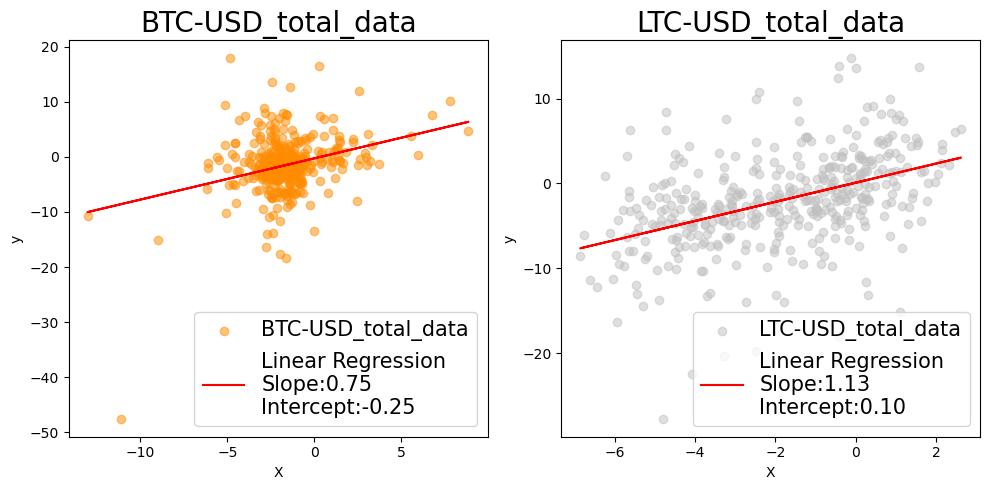

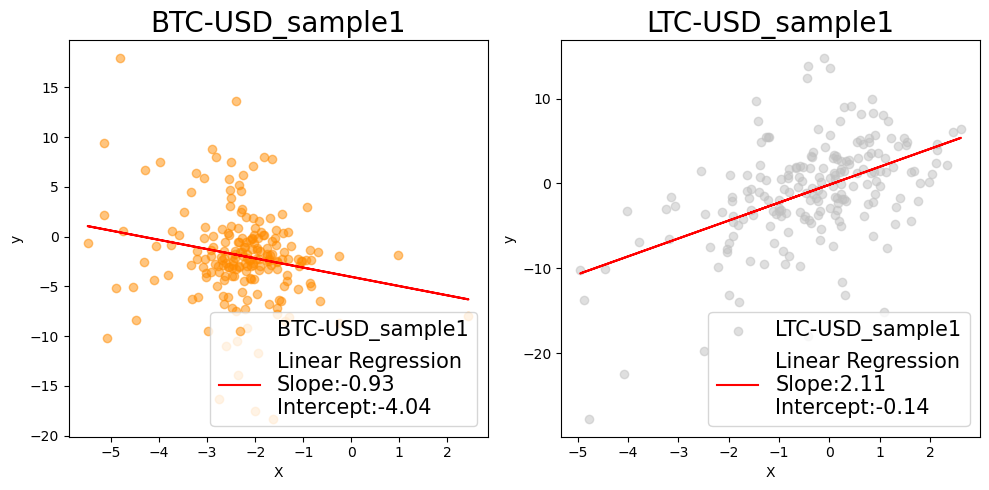

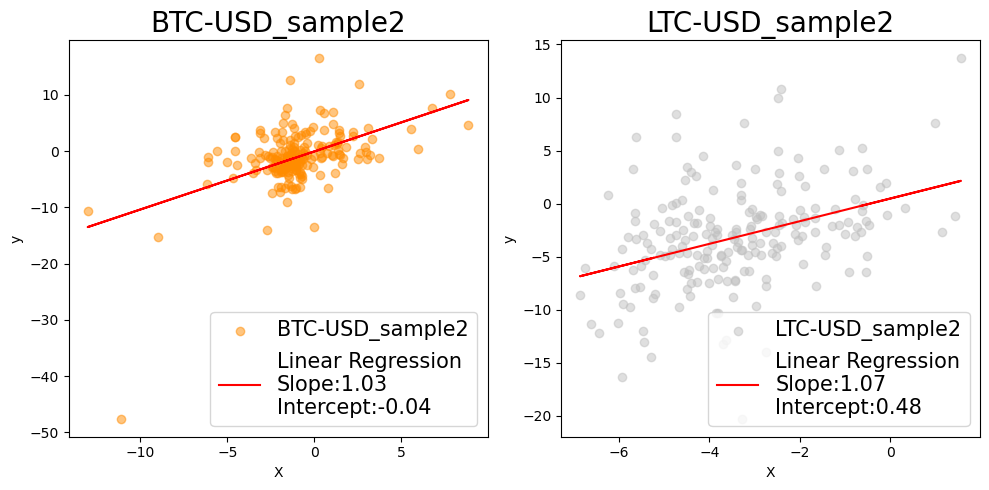

In [38]:

plots = arrange_plots(visualize_models,models = split_models1, fig_size = (10,5))
plots = arrange_plots(visualize_models,models = split_models2, fig_size = (10,5))
plots = arrange_plots(visualize_models,models = split_models3, fig_size = (10,5))

As you can see, these models do not seem to have anything in common at first glance. To examine this further, I will look at the regression outputs.

### Model Summaries

In [78]:
ones = []  
twos = []
for inst,model in split_models.items():
        html = f"<h2>{inst}</h2>{model['model'].summary().as_html()}"  
        if inst_list[0] in inst and not 'total' in inst:
            ones.append(html)
        elif inst_list[1] in inst and not 'total' in inst:
            twos.append(html)
    
display_html_side_by_side(ones)
display_html_side_by_side(twos)
split_date = max_chow[inst_list[0]]['split_date']
print(f'The split date for {inst_list[0]} is {split_date}')
split_date = max_chow[inst_list[1]]['split_date']
print(f'The split date for {inst_list[1]} is {split_date}')

The split date for BTC-USD is 2019-09-18
The split date for LTC-USD is 2022-06-23


#### Model Differences

Here, the BTC-USD model data was split on the 18th of September 2019, and LTC-USD was split on the 23rd of June 2022. As you can see, there are substantial differences in some of the critical model summary statistics. I will explore these differences below.<br><br><br>
<b>BTC-USD models</b>:<br><br><br>
<b>$R^2$:</b><br>
As you can see, the samples have a very different $R^2$ value. In the first sample, the variation in excess log-returns of the market explained less than 4% of the variation in BTC-USD's excess log returns. However, the $R^2$ value in the second sample is just below 25%, which is a better fit than the original BTC-USD model. I will continue my analysis below before proposing why this might be the case.<br>

<b>Coefficient and Statistical Significance:</b><br>
$\hat{\beta_1}$:
As you can see, the two samples have a vast difference in $\hat{\beta_1}$. Given a 1% increase in market excess returns, model 1 suggests that BTC-USD will decrease by 0.9287%, but the second model suggests that it will increase by 1.0337%. Furthermore, both of these coefficients are statistically significant(***). 

$\hat{\beta_0}$: There is a huge difference when it comes to the intercept terms similar to the slope term. The intercept for the first sample is almost ten times sample two's. As excess market returns approach zero, the excess log returns of BTC-USD according to model one approach -4.0354, but according to model two, they approach 0.0405. Unlike the $\hat{\beta_1}$'s, the intercept term in model 2 is not statistically significant, but in model 1, it is(***).<br><br><br>

<b>LTC-USD models</b>:<br><br><br>
<b>$R^2$:</b><br>
As you can see, the samples have a very different $R^2$ value. In the second sample, the variation in excess log-returns of the market explained less than 15% of the variation in LTC-USD's excess log returns. However, the $R^2$ value in the first sample is just below 25%, which is a better fit than the original LTC-USD model. I will continue my analysis below before proposing why this might be the case.<br>

<b>Coefficient and Statistical Significance:</b><br><br>
$\hat{\beta_1}$:
As you can see, the two samples have a vast difference in $\hat{\beta_1}$. Given a 1% increase in market excess returns, model one suggests that LTC-USD will increase by 2.1125%, but the second model suggests that it will increase by only 1.0679%. Furthermore, both of these coefficients are statistically significant(***). 

$\hat{\beta_0}$: There is a huge difference when it comes to the intercept terms similar to the slope term. As excess market returns approach zero, the excess log returns of LTC-USD, according to model one, approach 0.1367, but according to model two, they approach 0.4752. However, neither of these intercepts is statistically significant.<br><br>

<b>Why are the models so different?</b><br>
Given that the samples for each crypto are the ones that generate the largest chow statistic, we knew that the data would be better fit with two different regression lines rather than one. So, it is expected to have some large differences in the coefficients. However, to understand some possible reasons for the structural change around the 18th of September 2019 in BTC-USD and around the 23rd of June 2022, we will have to look back at the structure of the CAPM model itself. One possible explanation is that excess market returns do not have a direct linear relationship with the excess returns of the cryptocurrency. This would explain why 40% of all chow statistics generated for BTC-USD and 34% for LTC-USD are larger than the critical value. So, using a linear model to explain a non-linear relationship could lead to these structural breaks throughout the data. Another explanation is that the relationship between excess market returns and crypto returns may be linear. Still, there are several other variables we have not controlled for impacting the model fit. As we saw from the $R^2$ of the original models, only 15 and 9 per cent of the variation in excess log returns for BTC-USD and LTC-USD, respectively, are explained by the excess market returns. So, several other independent variables may be needed to model excess crypto returns. In this case, a large change in one of these unknown independent variables may explain the sizeable structural break for each crypto and the other statistically significant structural breaks throughout the data. An example of another independent variable which might explain the variation in excess crypto returns could be the number of positive social media posts about cryptocurrencies. Over the past years, cryptos such as BTC-USD and LTC-USD have gone through periods of high publicity and fanfare, which has driven up demand for the instruments. However, gathering data on a variable like this is beyond the scope of the Capital Asset Pricing Model.



---
# Question G

## The No Constant Model

Another way to fit a regression model to our data is using a no-constant model. As you can guess from the name, these models do not have a constant or $\hat{\beta_0}$ term. Instead the model is of the form : $\hat{Y_t} = \hat{\beta_1}X + \hat{u_t}$. This means that the regression line is forced through the origin rather than through the value of the intercept at 0. Fitting a model in this way can have some interesting results; however there are some downsides, so it should only be used under certain scenarios.<br><br>

<b>When can a no-constant regression model be used?<br>

In some cases, there may be a theoretical justification by which it is logical to have the regression line pass through the origin. For example, in the context of my models, I could take the view that when the excess log-returns of the market are zero, so should the excess log returns of both of my cryptos. If this was the case, forcing my model to fit through the origin would be logical.<br><br>

<b>What are the shortcomings of this approach?<br>

Biased Estimates: By omitting the intercept, our model could generate biased parameters and, as a result, biased estimates for Y. For example, we could get a biased estimate for $\hat{\beta_1}$, which leads to a loss of the model's predictive ability outside of the sample dataset and hinders the interpretation of the relationship between the independent and dependent variables.

Lack of Flexibility: By removing the intercept term, the model loses all flexibility in accounting for the behaviour of the dependent variable around zero values of the independent variable. However, as I stated above, if it is clear that the intercept should be zero, we do not care about not having this explanatory ability around zero.

$R^2$:<br>
As I mentioned in part c, the $R^2$ value is calculated as

$R^2 = \frac{ESS}{TSS}$
where $TSS = RSS+ESS$ 

TSS: Total sum of squares
ESS: Explained sum of squares
RSS: Residual sum of squares

However, the equality $TSS = RSS+ESS$ only holds when working with a model that has a constant. In the case of no constant models, this equality does not hold. As a result, the $R^2$ value is no longer bounded between 0 and 1



<br><br>

To investigate the changes that occur to our models when the constant term is not included, I have fit both models again, and you can see the regression outputs below.
    
Note: Given that I concluded in part c that it is usually best practice to use heteroskedastic robust standard error, I have done so for these models. For this reason, I will not be examining the heteroskedasticity of the models.






### Model Summaries

In [86]:
no_const_models = {f'No Const {inst}':generate_model(inst,with_const = 'N') for inst in inst_data.keys()}



for inst in inst_list:
    htmls = []
    models_ = [models[inst],no_const_models[f'No Const {inst}']]
    for i,model in enumerate(models_):
        if i == 1:
            html = f"<h2>Linear Regression Summary for No Const {inst}</h2>{model['model'].summary().as_html()}"  
        else:
            html = f"<h2>Linear Regression Summary for Main {inst}</h2>{model['model'].summary().as_html()}" 
        htmls.append(html)
    display_html_side_by_side(htmls)


### Coefficient and Fit Changes

Above, you can see the regression outputs for the const and no const models for BTC-USD and LTC-USD; there are various changes in the models, which I will discuss.

$R^2$:<br>
As I alluded to above, there has been a change in the $R^2$ value. This change has resulted in a 4.3 percentage point increase for BTC-USD and a 2.9 point increase for LTC-USD. Therefore, it appears that the no-const model is a better fit than the model with a const. However, given that $TSS \neq ESS+RSS$, the interpretation of $R^2$ as an exact measure of the explained variation in Y is less useful.

AIC, BIC and Log-Likelihood:<br>
Given that $R^2$ is a less meaningful statistic under no constant models I will look at the other measures of fit which we saw before AIC, BIC and Log-Likelihood. As you can see there has been no significant change in any of these measures. This indicates that the no constant model does not exhibit any improvement in model fit over the model with a constant.

$\hat{\beta_1}$:<br>
Notice that the coefficient of X has decreased from 1 to 0.9505 in BTC-USD and from 1.0793 to 1.0239 in LTC-USD. This decrease is due to the model adjusting to best fit the data, given that it must pass through the origin. The coefficient is still statistically significant($\text{***}$); however, as mentioned above, this adjustment can lead to $\hat{\beta_1}$ being a biased estimator.




### Residuals Changes

#### Serial Correlation

Next, I will consider serial correlation changes following the constant term's removal. I will look at the Durbin-Watson and Breusch-Godfrey tests to check for this.
In the regression outputs above, you can see a negligible change in the Durbin-Watson test statistic, so I conclude that removing the constant term has not had a statistically significant impact on first-order autocorrelation.
Sadly, the regression output does not generate a Breusch-Godfrey statistic, so I have carried it out using Python and presented the results below. As you can see, there has been a slight change in test-statistic; however, it is not enough to change the accepted hypothesis for each crypto model.
Overall, there seems to be a slight change in serial correlation by removing the constant term; however, in the case of the BTC-USD and LTC-USD model residuals, this change has not been significant enough to change my conclusions on serial correlation. However, if the original test statistics were close to a rejection region, removing the constant may be enough to change the statistically significant hypothesis.


In [41]:
breusch_godfrey(models)
breusch_godfrey(no_const_models)



Breusch Godfrey Lagrange Multiplier Statistic for BTC-USD is 14.556233478088304
p-value for BTC-USD is 0.26660585978943635
f-value for BTC-USD is 1.2133596335482422
f p-value for BTC-USD is 0.26734508940494817


Breusch Godfrey Lagrange Multiplier Statistic for LTC-USD is 27.64537800569236
p-value for LTC-USD is 0.006231889306760221
f-value for LTC-USD is 2.3197359733726297
f p-value for LTC-USD is 0.0060924459297146275


Breusch Godfrey Lagrange Multiplier Statistic for No Const BTC-USD is 15.601561572403604
p-value for No Const BTC-USD is 0.2101741453689475
f-value for No Const BTC-USD is 1.2286353767181046
f p-value for No Const BTC-USD is 0.2567588583798708


Breusch Godfrey Lagrange Multiplier Statistic for No Const LTC-USD is 28.2676428253738
p-value for No Const LTC-USD is 0.005054209422341856
f-value for No Const LTC-USD is 2.327241569982764
f p-value for No Const LTC-USD is 0.00591309795885298


#### Normality


To test for normality, I will look at the Jarque-Bera test statistic from the regression output. As you can see, the test statistic for each model has changed by removing the constant term. This effect is slightly increased, given that we rejected the null hypothesis that the residuals are normally distributed in part c. The increase in the test statistic means we still reject the null in favour of the alternative (residuals are not normally distributed). Therefore, the findings of this test have not changed; however, like with serial correlation, the original test statistics were near a rejection region. This change could be enough to reject the null. Below, I have produced the residual plots from part c to compare them with the no-constant plots. As you can see, they are almost identical.


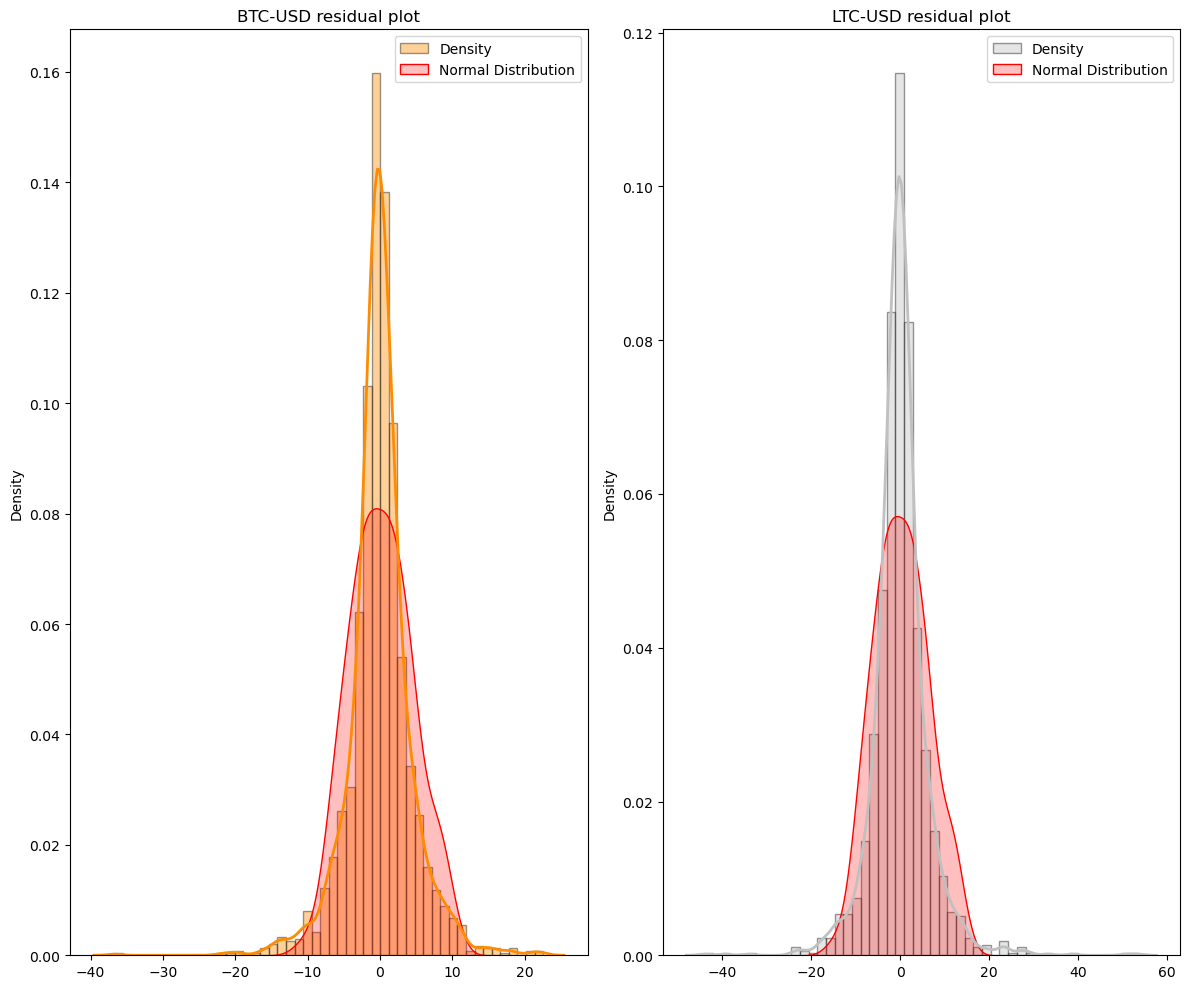

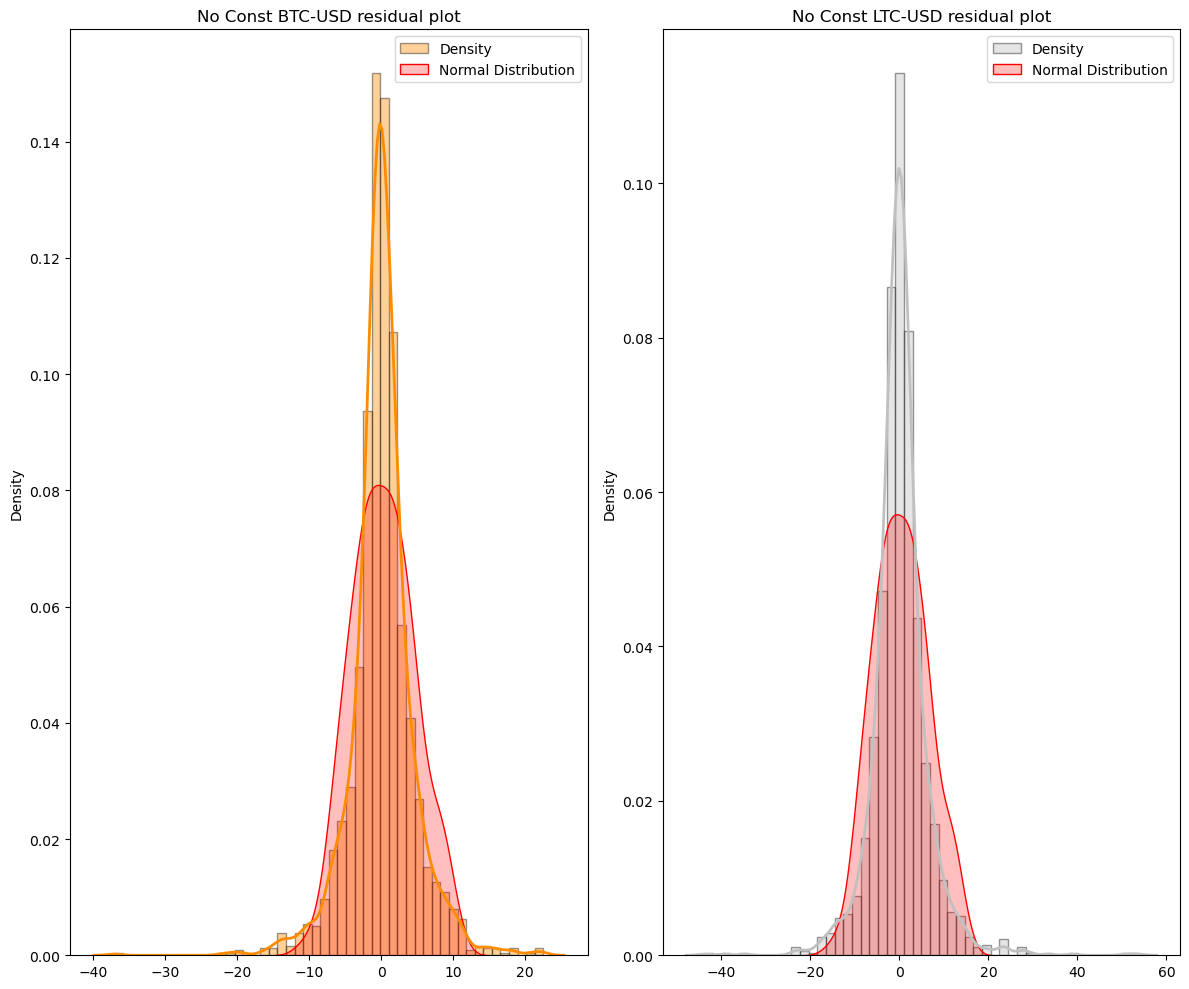

In [42]:
original = arrange_plots(resid_plot, fig_size = (12,10))
no_const = arrange_plots(resid_plot,models = no_const_models, fig_size = (12,10))

#### Conclusion of Residual Changes

The removal of the constant term did slightly impact the distribution of the model residuals compared to the original model. However, these small changes did not have enough impact to change the outcome of the tests.


### Summary

To conclude, removing the constant term can lead to biased estimates for $\hat{\beta_1}$, lack of flexibility when interpreting Y values around zero values of X, and it breaks the equality $TSS=ESS+RSS$ which makes the interpretation of $R^2$ difficult. However, there may be situations where theoretical reasons make it logical to pass the regression line through the original.

In the case of our crypto models, removing the constant had a slight change in $R^2$ but no change in AIC,BIC and Log-Likelihood. This indicates that there was no change in model fit and that the change in $R^2$ was due to the issue I mentioned above. $\hat{\beta_1}$ changed to compensate for the regression being forced through the origin. Regarding residuals, there were minor changes in test statistics for Serial Correlation and Normality, but they did not lead to any new findings.

So overall I conclude that removing the coefficient did not improve the model performance or fit. This result is expected as the intercept terms for the original were not statistically different from zero to begin with.

# Question H

Do you think CAPM is an appropriate tool to understand the dynamics of cryptocurrencies?

To examine whether CAPM is an appropriate tool to understand the dynamics of cryptocurrencies, I will discuss my findings from estimating the model for two cryptocurrencies and attempt to propose some explanation for my results concerning the dynamics of cryptocurrencies.

My findings
While completing this project, I reached some interesting conclusions about the quality of the CAPM for cryptocurrencies. I have presented my findings below.


In part c, I first estimated the CAPM model for both Bitcoin and Litecoin. By estimating the models, I generated a slope and intercept term. However my results from part c and part g also found that the intercept terms are not statistically significant. Infact in part f I found that removing the intercept term entirely did not have any impact on the fit of the models. This indicates that the CAPM may not be appropriate for cryptos as it assumes that $\hat{\beta_0}$ is not zero. The slope term represents the marginal effect ($\hat{\beta_1}$) of the market excess returns on each crypto excess return; for Bitcoin, I estimated a value of 1.00 and Litecoin, 1.0791. However, in part e, I found that with statistical significance ($\text{***}$), these values were not different from the $\beta$ of the market. This suggested that with every 1% increase in market excess returns, crypto excess returns would also increase by 1%, i.e. an elasticity of 1. However, before accepting this direct relationship, the quality of the model had first to be taken into consideration.

In part c, we saw from the $R^2$ values that the excess returns of the market account for only a tiny fraction of all variation in the excess returns of the cryptos. This explains why the first plot I produced at the start of this project showed a much more significant variance in excess returns for the cryptos than the market. Therefore, while the relationship defined by $\hat{\beta_1}$ may have been statistically significant, it is clear that there is much more variation to be accounted for. In part c, I also found that this model violated several of the assumptions of linear regression. For example, I could not conclude that the residuals were homoskedastic or normally distributed. While these issues can be fixed, for example, using heteroskedasticity robust standard errors, this is another indicator that the data may be better fit with another kind of model. The violation of these assumptions and the models' poor fit may indicate that CAPM is not an appropriate tool for understanding the dynamics of cryptocurrencies.

One reason we may not have captured all of the variance in the crypto excess returns could be because we assumed a linear relationship between excess market returns and excess crypto returns. It is possible that a non-linear relationship may better explain the relationship between these two variables. This theory is backed up by my findings in part f, that across all split points in the data for both cryptos, 40% for Bitcoin and 33% for Litecoin showed with statistical significance ($\text{***}$ that they would be better fit by two regression lines instead of one. This indicates that a non-linear model taking the shape of both better-fitting lines would better fit a single linear one.

Another reason that all variance is not accounted for could be that other variables are needed to explain the crypto excess returns fully. This would mean that market excess returns are just one piece in the crypto excess returns puzzle. However, as the CAPM is only dependent on the excess market returns, this theory suggests that CAPM is not an adequate tool for explaining crypto returns.

So overall, I have found that though the CAPM does provide a statistically significant $\hat{\beta_1}$ and explain some variation in crypto excess returns, it is not an appropriate tool to understand the dynamics of cryptocurrencies.


Why is this?<br>
There are various reasons why the CAPM may not be appropriate to price cryptocurrencies. Below, I have given a few examples.

Unique Characteristics of Cryptocurrencies
Cryptocurrencies have unique characteristics relative to other financial products such as bonds, equities and derivatives. These traditional instruments are tied to a tangible asset in some way and usually have cash flows; for example, equities entitle you to dividends, part ownership, and sometimes voting rights. However, cryptocurrencies do not have a corresponding real-world asset and do not have any cash flows. As a result of their, their returns come only from market speculation and investors' beliefs about decentralisation. As a result, the returns of a cryptocurrency may not be comparable to those of a traditional financial product, so the CAPM would not work.


Different Market Dynamics
Cryptocurrencies can often dwell outside global centralised finance (by construction). As such, they usually respond differently to market sentiment and news events when compared to the market. For example, in times of economic uncertainty and market downturn, investors may seek to refuse decentralised products such as Bitcoin, similar to how an investor would move their capital into gold. This difference in market dynamics may mean that CAPM may not be suitable to price cryptocurrencies.


Systematic Risk
Cryptocurrencies also face different risks than equities, meaning the market may not explain its returns well. For example, the price of cryptocurrencies is highly sensitive to risks relating to new regulations by governments and the bankruptcy of exchanges like FTX. Generally, the market does not price in these risks, which could mean that CAPM is not an appropriate tool to understand their dynamics.

So overall, it is clear that though CAPM is useful to a limited extent, there are a variety of factors which mean that it is not an appropriate tool to understand the dynamics of cryptocurrencies.



# Appendix

In [43]:
from yahoofinancials import YahooFinancials
from datetime import datetime

import pandas as pd
import requests

class price_data_generator:
    
    def __init__(self):       
        self.today_date : str = datetime.now().strftime('%Y-%m-%d')
        self.start_date : str = '2015-09-01'
        self.fred_api_key : str = '5e38d9310966ac372dbcbaa0ad94cdfa'

    def get_prices(self,ticker) -> pd.DataFrame: 
        yahoo_financials = YahooFinancials(ticker)
        try:
            historical_stock_prices : dict = yahoo_financials.get_historical_price_data(self.start_date, self.today_date, 'daily')
        except TypeError:
            print('Invalid ticker, try again')
        price_data : list = historical_stock_prices[ticker]['prices']
        
        data : list = []
        for day in price_data:
            date : str = day['formatted_date']
            adj_close_px : float = day['adjclose']
            close_px : float = day['close']
            high_px : float = day['high']
            low_px : float = day['low']
            open_px : float = day['open']
            data.append([date,close_px,adj_close_px,high_px,low_px,open_px])
        columns = ['date','close_px','adj_close_px','high_px','low_px','open_px']
        renamed_columns = [f'{ticker}_'+i if i != 'date' else i for i in columns]
        price_data : pd.DataFrame = pd.DataFrame(data,columns = renamed_columns)
          
        return price_data.reset_index(drop = True)
    
    def get_fred_data(self,inst):
        url : str = 'https://api.stlouisfed.org/fred/series/observations'

        params : dict = {
            'series_id': inst,     
            'api_key': self.fred_api_key,
            'file_type': 'json',      
            'observation_start': self.start_date,  
            'observation_end': self.today_date,    
        }
        
        response = requests.get(url, params=params)
        
        if response.status_code == 200:
            data = response.json()
            
        else:
            print(f"Error: {response.status_code}")
        
        price_data = []
        for day in data['observations']:
            date : str = day['date']
            if day['value'] != '.':
                price : float = float(day['value'])
                price_data.append([date,price])
                
        data : pd.DataFrame = pd.DataFrame(price_data,columns = ['date',f'{inst}_price'])
    
        return data
        